# Milestone 2

In [1]:
%cd ..
# imports 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scripts_m2 import *


c:\Users\001\OneDrive\Desktop\GUC\semester 10\nlp\NLP_PROJECT_111


### 1. Exploring the Dataset

In [2]:
# Loading the training data
import json 

with open('data/m2_train.json', 'r') as f:
    squad_data = json.load(f)

print(squad_data['data'][0]['paragraphs'][0].keys())

print(json.dumps(squad_data['data'][0], indent=2))

dict_keys(['qas', 'context'])
{
  "title": "Beyonc\u00e9",
  "paragraphs": [
    {
      "qas": [
        {
          "question": "When did Beyonce start becoming popular?",
          "id": "56be85543aeaaa14008c9063",
          "answers": [
            {
              "text": "in the late 1990s",
              "answer_start": 269
            }
          ],
          "is_impossible": false
        },
        {
          "question": "What areas did Beyonce compete in when she was growing up?",
          "id": "56be85543aeaaa14008c9065",
          "answers": [
            {
              "text": "singing and dancing",
              "answer_start": 207
            }
          ],
          "is_impossible": false
        },
        {
          "question": "When did Beyonce leave Destiny's Child and become a solo singer?",
          "id": "56be85543aeaaa14008c9066",
          "answers": [
            {
              "text": "2003",
              "answer_start": 526
            }
          ],


In [3]:
# Counting the number of answerable and unanswerable questions
num_answerable = 0
num_unanswerable = 0

for article in squad_data["data"]:
    for paragraph in article["paragraphs"]:
        for qa in paragraph["qas"]:
            if qa["is_impossible"]:
                num_unanswerable += 1
            else:
                num_answerable += 1

print("Number of answerable questions: ", num_answerable)
print("Number of unanswerable questions: ", num_unanswerable)
print("Number of QA pairs: ", num_answerable + num_unanswerable)

Number of answerable questions:  86821
Number of unanswerable questions:  43498
Number of QA pairs:  130319


Answerable vs. Unanswerable Questions in SQuAD 2.0

- **Answerable Questions:** The correct answer exists within the given passage, and the model must extract the exact span.
- **Unanswerable Questions:** The passage does not contain the answer, and the model should predict "No Answer."

SQuAD 2.0 introduces unanswerable questions to make the task more challenging, requiring models to distinguish between when an answer is present and when it is not.

In this notebook, we will use answerable questions only in the subset we will be training our neural networks on

### 2. Preprocessing the dataset

In [4]:
# Clean text function
import re

def clean_text(text: str, is_question: bool=False):
    """
    Cleans text by removing extra spaces, newline characters, and special symbols.
    """
    if is_question:
        text = text.replace("\n", " ").replace("\t", " ")  # Remove newlines & tabs
        text = re.sub(r"\s+", " ", text)  # Remove extra spaces
        text = text.strip()  # Trim leading/trailing spaces
    text = text.lower()  # Convert to lowercase
    return text

# Testing the clean_text function on a sample text
sample_text = "   This is a \n\n\t sample    text.    "
print("Original text:", sample_text)
print("Cleaned text:", clean_text(sample_text))

Original text:    This is a 

	 sample    text.    
Cleaned text:    this is a 

	 sample    text.    


In [5]:
# Load and process the SQuAD dataset using the clean_text function
import json

def load_and_process_squad(filepath, max_samples=20000):
    """
    Loads, cleans, and extracts answerable questions from the SQuAD dataset.

    Args:
        filepath (str): Path to the SQuAD JSON file.
        max_samples (int): Maximum number of answerable questions to load.

    Returns:
        List[dict]: A list of cleaned question-answer pairs.
    """
    with open(filepath, "r") as f:
        squad_data = json.load(f)

    data = []
    for article in squad_data["data"]:
        for paragraph in article["paragraphs"]:
            context = clean_text(paragraph["context"]) 
            for qa in paragraph["qas"]:
                if qa["is_impossible"]:  
                    continue
                
                question = clean_text(qa["question"], is_question=True) 
                answer_text = clean_text(qa["answers"][0]["text"])  
                answer_start = qa["answers"][0]["answer_start"]
                
                data.append({
                    "context": context, 
                    "question": question, 
                    "answer": answer_text, 
                    "answer_start": answer_start, 
                    "answer_end": answer_start + len(answer_text)})


    data.sort(key=lambda x: (len(x["context"]), len(x["question"])))
    # Limit the number of samples if specified
    if max_samples > 0:
        data = data[:max_samples]
    return data

# Load and process the SQuAD dataset
train_dataset = load_and_process_squad("data/m2_train.json", max_samples=-1)
dev_samples = load_and_process_squad("data/m2_dev.json", max_samples=2000)

print("Number of QA pairs in train data:", len(train_dataset))
print("Training sample:", train_dataset[0].keys())
print("\n")
print("Number of QA pairs in test data:", len(dev_samples))
print("Dev sample:", dev_samples[0].keys())


Number of QA pairs in train data: 86821
Training sample: dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])


Number of QA pairs in test data: 2000
Dev sample: dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])


### 3. Tokenization

In [6]:
unique_words = set()

for sample in train_dataset:
    context = sample["context"]
    question = sample["question"]
    answer = sample["answer"]

    unique_words.update(set(re.findall(r"\w+", context)))
    unique_words.update(set(re.findall(r"\w+", question)))
    unique_words.update(set(re.findall(r"\w+", answer)))

                
# Print the number of unique words
print("Number of unique words in the training set:", len(unique_words))

Number of unique words in the training set: 82597


In [7]:
combined_text = []
for sample in train_dataset:
    combined_text.append(sample["context"])
    combined_text.append(sample["question"])
    combined_text.append(sample["answer"])

# Join all text samples into one corpus (you can also use '\n'.join for a more distinct separation)
combined_text = "\n".join(combined_text)


In [8]:
# Training the tokenizer
from scripts_m2 import *

# Creating / Loading the tokenizer
tokenizer = BPETokenizer()

# Training the tokenizer if not already trained
tokenizer.train(combined_text=combined_text.split("/n"), vocab_size=10000)


Loading tokenizer from ./tokenizers/tokenizer.json...
Tokenizer already exists at ./tokenizers/tokenizer.json. Skipping training.


In [9]:
# Encoding a Question
example_question = train_dataset[4]["question"]
tokenized_output, attention_mask = tokenizer.encode(example_question)
print("Tokenized Question:", tokenized_output)
print("Length of Tokenized Question:", len(tokenized_output))
print("Attention Mask:", attention_mask)

# Decoding the tokenized output
decoded_output = tokenizer.decode(tokenized_output)
print("Decoded Question:", decoded_output)

Tokenized Question: [3, 2441, 1997, 1966, 4721, 2776, 1974, 3539, 1978, 7873, 3120, 1390, 4]
Length of Tokenized Question: 13
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Decoded Question: where is the oklahoma school of science and mathematics located ?


In [10]:
# Changing the max tokenizer length
tokenizer.set_max_length(25)

In [11]:
# Encoding an answer
example_answer = train_dataset[4]["answer"]
tokenized_answer, attention_mask = tokenizer.encode(example_answer)
print("Tokenized Answer:", tokenized_answer)
print("Length of Tokenized Answer:", len(tokenized_answer))
print("Attention Mask:", attention_mask)

# Decoding the tokenized answer
decoded_answer = tokenizer.decode(tokenized_answer)
print("Decoded Answer:", decoded_answer)

Tokenized Answer: [3, 4721, 2251, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Length of Tokenized Answer: 25
Attention Mask: [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded Answer: oklahoma city


### 4. Dataset & Data Loaders

In [12]:
# Getting the dataset
train_dataset = load_and_process_squad("data/m2_train.json", max_samples=20000)
dev_dataset = load_and_process_squad("data/m2_dev.json", max_samples=2000)
print("Number of training samples:", len(train_dataset))
print("Number of dev samples:", len(dev_dataset))

Number of training samples: 20000
Number of dev samples: 2000


In [13]:
# Create the tokenizer
tokenizer = BPETokenizer()
# Train the tokenizer
tokenizer.train(combined_text=combined_text.split("\n"), vocab_size=10000)

Loading tokenizer from ./tokenizers/tokenizer.json...
Tokenizer already exists at ./tokenizers/tokenizer.json. Skipping training.


In [14]:
# View the training data
random_idx = np.random.randint(0, len(train_dataset))

# Print the random sample
print(train_dataset[random_idx].keys())
print("Training data sample:")
print(train_dataset[random_idx]["context"])
print(train_dataset[random_idx]["question"])
print(train_dataset[random_idx]["answer"])
print("Answer start:", train_dataset[random_idx]["answer_start"])
print("Answer end:", train_dataset[random_idx]["answer_end"])
print("Length of the training examples:", len(train_dataset))

dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])
Training data sample:
it is not only the proportion of latewood, but also its quality, that counts. in specimens that show a very large proportion of latewood it may be noticeably more porous and weigh considerably less than the latewood in pieces that contain but little. one can judge comparative density, and therefore to some extent strength, by visual inspection.
what can we judge in wood just by looking at it?
comparative density
Answer start: 265
Answer end: 284
Length of the training examples: 20000


In [15]:
q = tokenizer.encode(train_dataset[4]["question"])[0]
tokenizer.decode(q)

'where is the oklahoma school of science and mathematics located ?'

In [16]:
# Viewing the length of the longest question, context, and answer
max_context_length = max(len(tokenizer.encode(sample["context"])[0]) for sample in train_dataset)
max_question_length = max(len(tokenizer.encode(sample["question"])[0]) for sample in train_dataset)
max_answer_length = max(len(tokenizer.encode(sample["answer"])[0]) for sample in train_dataset)

print("Max context length:", max_context_length)
print("Max question length:", max_question_length)
print("Max answer length:", max_answer_length)

Max context length: 205
Max question length: 64
Max answer length: 75


Summary Statistics for Context Lengths:
Number of questions: 20000
Number of outliers: 18
Minimum: 29
Q1 (25%): 83.0
Median: 110.0
Q3 (75%): 124.0
Maximum: 205
Interquartile Range (IQR): 41.0
95th Percentile: 143.0
97th Percentile: 149.0
99th Percentile: 160.0


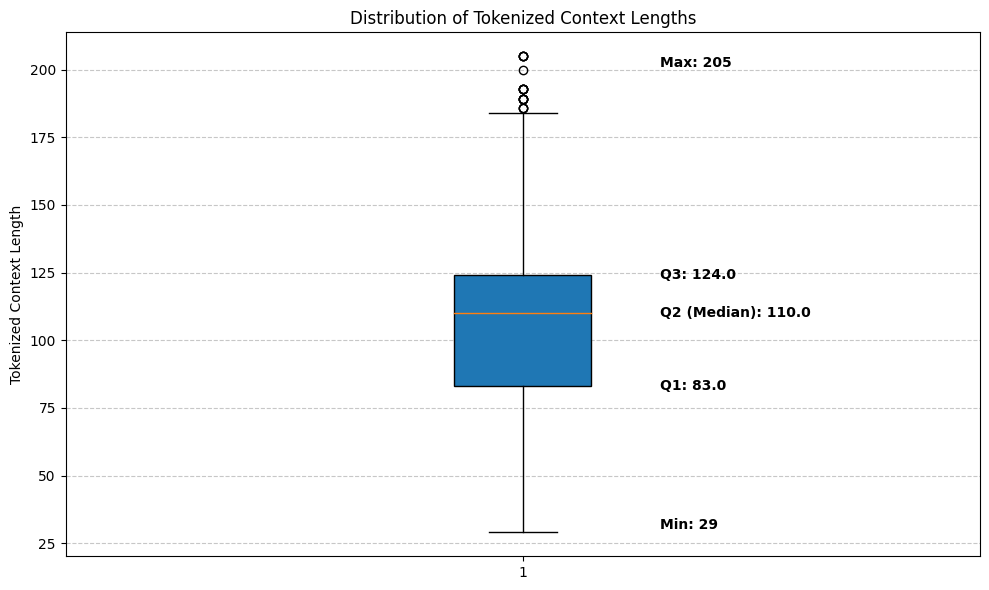

In [17]:
# Visualizing the distribution of tokenized question lengths
context_lengths = [len(tokenizer.encode(sample["context"])[0]) for sample in train_dataset]
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(context_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Context Lengths")
plt.ylabel("Tokenized Context Length")

# Calculate and display quartiles
quartiles = np.percentile(context_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(context_lengths)
max_val = np.max(context_lengths)

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}', 
         verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}', 
         verticalalignment='top', fontweight='bold')

print(f"Summary Statistics for Context Lengths:")
print("Number of questions:", len(context_lengths))
print("Number of outliers:", len([x for x in context_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in context_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Summary Statistics for Question Lengths:
Number of questions: 20000
Number of outliers: 407
Minimum: 6
Q1 (25%): 12.0
Median: 15.0
Q3 (75%): 18.0
Maximum: 64
Interquartile Range (IQR): 6.0
95th Percentile: 24.0
97th Percentile: 26.0
99th Percentile: 30.0


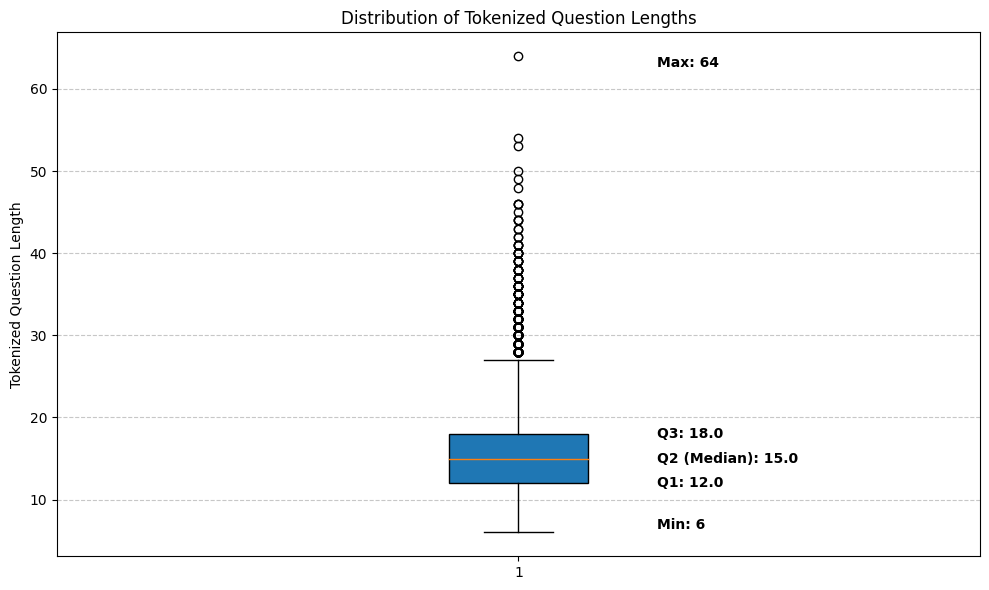

In [18]:
# Visualizing the distribution of tokenized question lengths
question_lengths = [len(tokenizer.encode(sample["question"])[0]) for sample in train_dataset]
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(question_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Question Lengths")
plt.ylabel("Tokenized Question Length")

# Calculate and display quartiles
quartiles = np.percentile(question_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(question_lengths)
max_val = np.max(question_lengths)

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}', 
         verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}', 
         verticalalignment='top', fontweight='bold')

print(f"Summary Statistics for Question Lengths:")
print("Number of questions:", len(question_lengths))
print("Number of outliers:", len([x for x in question_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in question_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Summary Statistics for Answer Lengths:
Number of answers:  20000
Number of outliers:  1705
Minimum: 3
Q1 (25%): 4.0
Median: 5.0
Q3 (75%): 7.0
Maximum: 75
Interquartile Range (IQR): 3.0
95th Percentile: 14.0
97th Percentile: 18.0
99th Percentile: 25.0


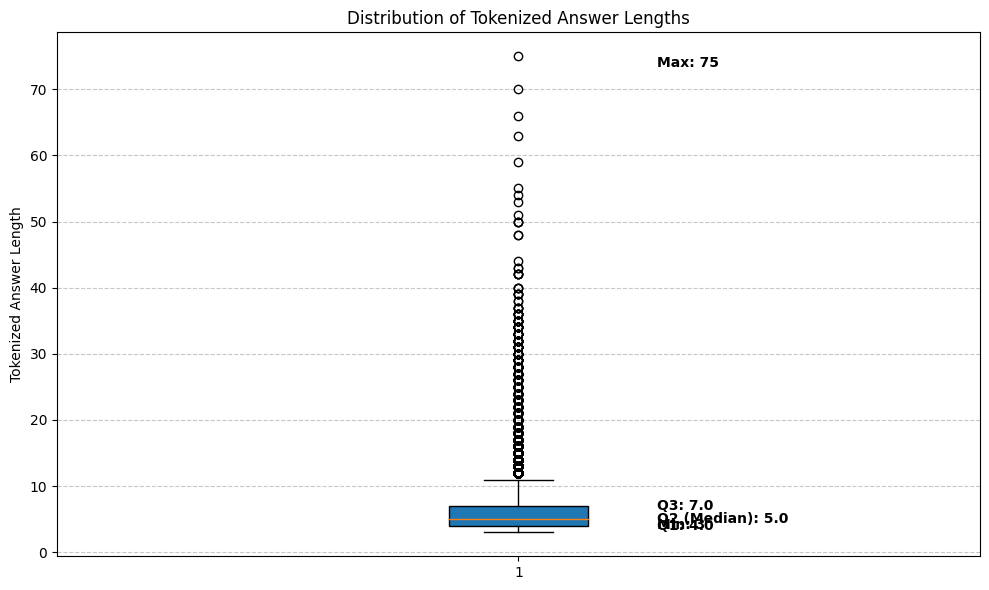

In [19]:
# Visualizing the distribution of tokenized answer lengths
answer_lengths = [len(tokenizer.encode(sample["answer"])[0]) for sample in train_dataset]

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(answer_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Answer Lengths")
plt.ylabel("Tokenized Answer Length")
# Calculate and display quartiles
quartiles = np.percentile(answer_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(answer_lengths)
max_val = np.max(answer_lengths)

print(f"Summary Statistics for Answer Lengths:")
print("Number of answers: ", len(answer_lengths))
print("Number of outliers: ", len([x for x in answer_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in answer_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}',
            verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}',
            verticalalignment='top', fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Summary Statistics for context + question Lengths:
Number of context + question:  20000
Number of outliers:  10
Minimum: 39
Q1 (25%): 97.0
Median: 124.0
Q3 (75%): 139.0
Maximum: 224
Interquartile Range (IQR): 42.0
95th Percentile: 159.0
97th Percentile: 164.0
99th Percentile: 175.0


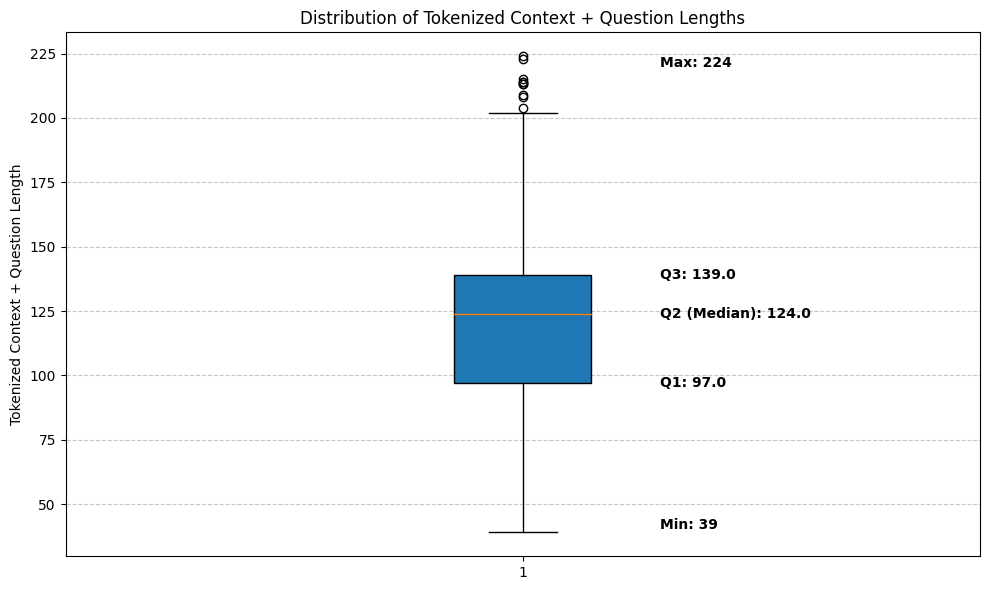

In [20]:
# Visualizing the distribution of tokenized answer lengths
context_question_lengths = [len(tokenizer.encode_two_texts(sample["context"], sample["question"])[0]) for sample in train_dataset]

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(context_question_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Context + Question Lengths")
plt.ylabel("Tokenized Context + Question Length")
# Calculate and display quartiles
quartiles = np.percentile(context_question_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(context_question_lengths)
max_val = np.max(context_question_lengths)

print(f"Summary Statistics for context + question Lengths:")
print("Number of context + question: ", len(context_question_lengths))
print("Number of outliers: ", len([x for x in context_question_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in context_question_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}',
            verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}',
            verticalalignment='top', fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

So for the transformer based models we can use the max length of the question and answer as follows:
1. `Answers Max Length`: 25 tokens
2. `Question Max Length`: 30 tokens
3. `Context Max Length`: 160 tokens
4. `Context + Question Length`: 160+30+1 (+1 for [SEP]) We could have used 175 as it is the 99th percentile but we will use 191 instead


This would give us a good tradeoff between the length of the sequence without using a lot of padding.

In [21]:
# Creating dataset
tokenizer = BPETokenizer()
train_data = load_and_process_squad("data/m2_train.json", max_samples=20000)
dev_data = load_and_process_squad("data/m2_dev.json", max_samples=2000)

context_max_length = 160
question_max_length = 30
answer_max_length = 25
train_dataset = QADataset(train_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True)
dev_dataset = QADataset(dev_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True)
print("Number of training samples:", len(train_dataset))
print("Number of dev samples:", len(dev_dataset))

# View a sample from the dataset
random_idx = np.random.randint(0, len(train_dataset))
print("Sample from the dataset:")
print("Question encoded:", train_dataset[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(train_dataset[random_idx]["question"].tolist()))
print("Answer encoded:", train_dataset[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(train_dataset[random_idx]["answer"].tolist()))
print("Context encoded:", train_dataset[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(train_dataset[random_idx]["context"].tolist()))
print("\n\n")

# View a sample from the dev dataset
random_idx = np.random.randint(0, len(dev_dataset))
print("Sample from the dev dataset:")
print("Context encoded:", dev_dataset[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(dev_dataset[random_idx]["context"].tolist()))
print("Question encoded:", dev_dataset[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(dev_dataset[random_idx]["question"].tolist()))
print("Answer encoded:", dev_dataset[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(dev_dataset[random_idx]["answer"].tolist()))
print("Context Question encoded:", dev_dataset[random_idx]["context_question"])
print("Context Question decoded: ", tokenizer.decode(dev_dataset[random_idx]["context_question"].tolist()))
print("Answer Start:", dev_dataset[random_idx]["answer_start"])
print("Answer End:", dev_dataset[random_idx]["answer_end"])
print("Answer Start: End decoded:", tokenizer.decode(dev_dataset[random_idx]["context"][dev_dataset[random_idx]["answer_start"]:dev_dataset[random_idx]["answer_end"]+1].tolist()))


Loading tokenizer from ./tokenizers/tokenizer.json...
Filtered dataset size: 19993 out of original 20000
Filtered dataset size: 1996 out of original 2000
Number of training samples: 19993
Number of dev samples: 1996
Sample from the dataset:
Question encoded: tensor([   3, 2087, 1997, 1966, 2996, 4428, 2273, 1989, 6508, 1966, 3985, 2065,
        1979, 1966, 3263, 2405, 1974, 2996, 3299, 1390,    4,    1,    1,    1,
           1,    1,    1,    1,    1,    1])
Question decoded:  what is the main material used to build the cellar in the basement of main building ?
Answer encoded: tensor([   3, 2247, 4043,    4,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1])
Answer decoded:  brick
Context encoded: tensor([   3, 4831, 2079, 2835, 1359, 1266, 8295, 3985, 2065, 1996, 1966, 4440,
        1974, 5397, 4517, 1283, 3253, 1979, 3241, 3355, 1381, 3241, 3410, 2038,
        7705, 6287, 6187, 1283, 1997, 19

In [22]:
# Creating Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) # add this `num_workers=0` if you want to see print in __getitem__ in dataset class
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

for batch in train_dataloader:
    print(batch.keys())
    print(batch['context_question'].shape)
    print(batch['question'].shape)
    print(batch['answer'].shape)
    print(batch['attention_mask_question'].shape)
    print(batch['attention_mask_answer'].shape)
    print(batch['attention_mask_context_question'].shape)
    print(batch['answer_start'], batch['answer_end'])
    print("-" * 50)

dict_keys(['question', 'attention_mask_question', 'answer', 'attention_mask_answer', 'context', 'attention_mask_context', 'context_question', 'attention_mask_context_question', 'answer_start', 'answer_end'])
torch.Size([32, 191])
torch.Size([32, 30])
torch.Size([32, 25])
torch.Size([32, 30])
torch.Size([32, 25])
torch.Size([32, 191])
tensor([ 90,  12,  16,  61,  22,  23,  19,  27,  10,  17, 100,  32, 103,  57,
         46,   0,  11,  23,  15,  58,   8,  50,  24,  52,  29,  37,  55,   0,
         47,  46,  29,  21]) tensor([ 91,  18,  20,  61,  25,  29,  25,  31,  13,  22, 107,  33, 112,  58,
         60,   4,  11,  23,  16,  70,  12,  51,  38,  52,  32,  39,  58,  17,
         47,  49,  31,  24])
--------------------------------------------------
dict_keys(['question', 'attention_mask_question', 'answer', 'attention_mask_answer', 'context', 'attention_mask_context', 'context_question', 'attention_mask_context_question', 'answer_start', 'answer_end'])
torch.Size([32, 191])
torch.Size([3

### 5. Phase 1: Model Training

#### Context [SEP] Question

In [23]:
vocab_size = 10000

# Initialize the model
model = RNN_QA_Model(
    vocab_size=vocab_size,
    embedding_dim=256,
    hidden_dim=256,
    num_layers=3,
    dropout=0.5,
    pad_idx=1
)

#  loss function
criterion = nn.CrossEntropyLoss()
#  optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
# Training the model
train_qa_context_model(
    model=model, 
    train_dataloader=train_dataloader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=50,
    device='cuda', 
    val_dataloader=dev_dataloader, 
    evaluate_val_dataset=True
)

Epoch 1/50: 100%|██████████| 625/625 [00:13<00:00, 46.76it/s, loss=6.52]


Epoch 1 Loss: 7.7158


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 60.86it/s]


Validation Loss: 7.6206
Validation Metrics: {'start_accuracy': 0.08216432865731463, 'start_precision': 0.08784456494918455, 'start_recall': 0.08216432865731463, 'start_f1_score': 0.07825977613824404, 'end_accuracy': 0.09168336673346693, 'end_precision': 0.09137172274059968, 'end_recall': 0.09168336673346693, 'end_f1_score': 0.08528390412564232, 'joint_exact_match': 0.024549098196392786, 'span_overlap_f1': 0.06088804753580131}


Epoch 2/50: 100%|██████████| 625/625 [00:13<00:00, 46.46it/s, loss=6.8] 


Epoch 2 Loss: 7.1858


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 60.48it/s]


Validation Loss: 7.7867
Validation Metrics: {'start_accuracy': 0.0811623246492986, 'start_precision': 0.08365035911246604, 'start_recall': 0.0811623246492986, 'start_f1_score': 0.07581565350198566, 'end_accuracy': 0.08366733466933868, 'end_precision': 0.07222468673574467, 'end_recall': 0.08366733466933868, 'end_f1_score': 0.0707134317967252, 'joint_exact_match': 0.02004008016032064, 'span_overlap_f1': 0.05533935375528682}


Epoch 3/50: 100%|██████████| 625/625 [00:13<00:00, 46.37it/s, loss=7.42]


Epoch 3 Loss: 6.7167


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.49it/s]


Validation Loss: 7.5606
Validation Metrics: {'start_accuracy': 0.08767535070140281, 'start_precision': 0.0842003923703452, 'start_recall': 0.08767535070140281, 'start_f1_score': 0.07943862907756531, 'end_accuracy': 0.09018036072144289, 'end_precision': 0.0894025599067649, 'end_recall': 0.09018036072144289, 'end_f1_score': 0.07950637694362112, 'joint_exact_match': 0.03206412825651302, 'span_overlap_f1': 0.06359990012204257}


Epoch 4/50: 100%|██████████| 625/625 [00:13<00:00, 46.29it/s, loss=7.62]


Epoch 4 Loss: 6.2998


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 56.59it/s]


Validation Loss: 7.6494
Validation Metrics: {'start_accuracy': 0.09719438877755511, 'start_precision': 0.0893825063332601, 'start_recall': 0.09719438877755511, 'start_f1_score': 0.08514701347261106, 'end_accuracy': 0.0966933867735471, 'end_precision': 0.08611839361647919, 'end_recall': 0.0966933867735471, 'end_f1_score': 0.08489628359608191, 'joint_exact_match': 0.036072144288577156, 'span_overlap_f1': 0.07092690680662828}


Epoch 5/50: 100%|██████████| 625/625 [00:13<00:00, 46.36it/s, loss=6.39]


Epoch 5 Loss: 5.9899


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 60.89it/s]


Validation Loss: 7.7686
Validation Metrics: {'start_accuracy': 0.09819639278557114, 'start_precision': 0.09674655679549422, 'start_recall': 0.09819639278557114, 'start_f1_score': 0.09183084772598536, 'end_accuracy': 0.09719438877755511, 'end_precision': 0.08496588194560256, 'end_recall': 0.09719438877755511, 'end_f1_score': 0.08509197705714876, 'joint_exact_match': 0.04408817635270541, 'span_overlap_f1': 0.07836650157844181}


Epoch 6/50: 100%|██████████| 625/625 [00:13<00:00, 46.92it/s, loss=5.69]


Epoch 6 Loss: 5.7068


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 59.57it/s]


Validation Loss: 8.0832
Validation Metrics: {'start_accuracy': 0.09468937875751503, 'start_precision': 0.09267473128745354, 'start_recall': 0.09468937875751503, 'start_f1_score': 0.0869932121381396, 'end_accuracy': 0.09919839679358718, 'end_precision': 0.09289729538725193, 'end_recall': 0.09919839679358718, 'end_f1_score': 0.08917738664111341, 'joint_exact_match': 0.03707414829659319, 'span_overlap_f1': 0.07323537262496906}


Epoch 7/50: 100%|██████████| 625/625 [00:13<00:00, 47.70it/s, loss=5.75]


Epoch 7 Loss: 5.4105


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.21it/s]


Validation Loss: 8.2478
Validation Metrics: {'start_accuracy': 0.093687374749499, 'start_precision': 0.08801059753495605, 'start_recall': 0.093687374749499, 'start_f1_score': 0.08483037463447647, 'end_accuracy': 0.09118236472945891, 'end_precision': 0.0846650146818527, 'end_recall': 0.09118236472945891, 'end_f1_score': 0.0810033096771122, 'joint_exact_match': 0.04308617234468938, 'span_overlap_f1': 0.07565305001161385}


Epoch 8/50: 100%|██████████| 625/625 [00:13<00:00, 48.03it/s, loss=5]   


Epoch 8 Loss: 5.0846


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 64.34it/s]


Validation Loss: 8.8936
Validation Metrics: {'start_accuracy': 0.08066132264529058, 'start_precision': 0.0735532333715045, 'start_recall': 0.08066132264529058, 'start_f1_score': 0.0669081085468651, 'end_accuracy': 0.08767535070140281, 'end_precision': 0.08614645797846895, 'end_recall': 0.08767535070140281, 'end_f1_score': 0.07780256591644372, 'joint_exact_match': 0.03256513026052104, 'span_overlap_f1': 0.06808839233797154}


Epoch 9/50: 100%|██████████| 625/625 [00:12<00:00, 48.23it/s, loss=4.93]


Epoch 9 Loss: 4.8059


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 62.72it/s]


Validation Loss: 9.1814
Validation Metrics: {'start_accuracy': 0.09118236472945891, 'start_precision': 0.08333511834999413, 'start_recall': 0.09118236472945891, 'start_f1_score': 0.07918260031008897, 'end_accuracy': 0.08016032064128256, 'end_precision': 0.07809112134905873, 'end_recall': 0.08016032064128256, 'end_f1_score': 0.07193130621200164, 'joint_exact_match': 0.033066132264529056, 'span_overlap_f1': 0.0665695581918706}


Epoch 10/50: 100%|██████████| 625/625 [00:13<00:00, 47.39it/s, loss=5.22]


Epoch 10 Loss: 4.5488


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.44it/s]


Validation Loss: 9.6084
Validation Metrics: {'start_accuracy': 0.08216432865731463, 'start_precision': 0.07839394240354328, 'start_recall': 0.08216432865731463, 'start_f1_score': 0.07286083962367021, 'end_accuracy': 0.08667334669338678, 'end_precision': 0.08291753729292645, 'end_recall': 0.08667334669338678, 'end_f1_score': 0.07806535220639751, 'joint_exact_match': 0.028056112224448898, 'span_overlap_f1': 0.06438999009942044}


Epoch 11/50: 100%|██████████| 625/625 [00:12<00:00, 48.46it/s, loss=4.16]


Epoch 11 Loss: 4.3202


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.09it/s]


Validation Loss: 10.3559
Validation Metrics: {'start_accuracy': 0.07965931863727455, 'start_precision': 0.07438974329348991, 'start_recall': 0.07965931863727455, 'start_f1_score': 0.07181477280192786, 'end_accuracy': 0.08216432865731463, 'end_precision': 0.07719468525728934, 'end_recall': 0.08216432865731463, 'end_f1_score': 0.07519147145959618, 'joint_exact_match': 0.02655310621242485, 'span_overlap_f1': 0.05783906665848703}


Epoch 12/50: 100%|██████████| 625/625 [00:13<00:00, 47.62it/s, loss=4.34]


Epoch 12 Loss: 4.1442


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.33it/s]


Validation Loss: 10.5947
Validation Metrics: {'start_accuracy': 0.08567134268537074, 'start_precision': 0.07822457758004048, 'start_recall': 0.08567134268537074, 'start_f1_score': 0.07373314023288104, 'end_accuracy': 0.08066132264529058, 'end_precision': 0.07769021435657271, 'end_recall': 0.08066132264529058, 'end_f1_score': 0.07178729629862987, 'joint_exact_match': 0.02655310621242485, 'span_overlap_f1': 0.06159627745128422}


Epoch 13/50: 100%|██████████| 625/625 [00:13<00:00, 47.90it/s, loss=3.82]


Epoch 13 Loss: 3.9863


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 59.54it/s]


Validation Loss: 10.4436
Validation Metrics: {'start_accuracy': 0.0746492985971944, 'start_precision': 0.06362230341406114, 'start_recall': 0.0746492985971944, 'start_f1_score': 0.06206356393511729, 'end_accuracy': 0.06162324649298597, 'end_precision': 0.06274869953913009, 'end_recall': 0.06162324649298597, 'end_f1_score': 0.05693064539908484, 'joint_exact_match': 0.016533066132264528, 'span_overlap_f1': 0.058353076890988814}


Epoch 14/50: 100%|██████████| 625/625 [00:13<00:00, 47.92it/s, loss=4.21]


Epoch 14 Loss: 3.8534


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.75it/s]


Validation Loss: 11.7263
Validation Metrics: {'start_accuracy': 0.061122244488977955, 'start_precision': 0.05185911867564638, 'start_recall': 0.061122244488977955, 'start_f1_score': 0.05264575844624525, 'end_accuracy': 0.07515030060120241, 'end_precision': 0.07329259257570069, 'end_recall': 0.07515030060120241, 'end_f1_score': 0.0692851300208513, 'joint_exact_match': 0.01753507014028056, 'span_overlap_f1': 0.06021468129859597}


Epoch 15/50: 100%|██████████| 625/625 [00:13<00:00, 47.58it/s, loss=3.85]


Epoch 15 Loss: 3.7174


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 65.37it/s]


Validation Loss: 11.7528
Validation Metrics: {'start_accuracy': 0.06513026052104208, 'start_precision': 0.058785100192159746, 'start_recall': 0.06513026052104208, 'start_f1_score': 0.055223657735248774, 'end_accuracy': 0.07064128256513026, 'end_precision': 0.07199723737072745, 'end_recall': 0.07064128256513026, 'end_f1_score': 0.06544998422438242, 'joint_exact_match': 0.021042084168336674, 'span_overlap_f1': 0.06096496737716035}


Epoch 16/50: 100%|██████████| 625/625 [00:13<00:00, 48.06it/s, loss=3.54]


Epoch 16 Loss: 3.6458


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.66it/s]


Validation Loss: 11.4283
Validation Metrics: {'start_accuracy': 0.06212424849699399, 'start_precision': 0.060934177858856194, 'start_recall': 0.06212424849699399, 'start_f1_score': 0.05808567282722514, 'end_accuracy': 0.0746492985971944, 'end_precision': 0.08803448411962826, 'end_recall': 0.0746492985971944, 'end_f1_score': 0.07094066245852722, 'joint_exact_match': 0.02404809619238477, 'span_overlap_f1': 0.06354540782512336}


Epoch 17/50: 100%|██████████| 625/625 [00:12<00:00, 48.86it/s, loss=3.67]


Epoch 17 Loss: 3.5406


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 64.66it/s]


Validation Loss: 12.0771
Validation Metrics: {'start_accuracy': 0.07064128256513026, 'start_precision': 0.07327850950890649, 'start_recall': 0.07064128256513026, 'start_f1_score': 0.06595566498189397, 'end_accuracy': 0.0811623246492986, 'end_precision': 0.0921144996205529, 'end_recall': 0.0811623246492986, 'end_f1_score': 0.07858615372186263, 'joint_exact_match': 0.02655310621242485, 'span_overlap_f1': 0.06761679941032658}


Epoch 18/50: 100%|██████████| 625/625 [00:13<00:00, 47.45it/s, loss=3.43]


Epoch 18 Loss: 3.4674


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 56.78it/s]


Validation Loss: 12.4993
Validation Metrics: {'start_accuracy': 0.08166332665330661, 'start_precision': 0.08281911123190895, 'start_recall': 0.08166332665330661, 'start_f1_score': 0.07515140508376308, 'end_accuracy': 0.08567134268537074, 'end_precision': 0.09806087142538261, 'end_recall': 0.08567134268537074, 'end_f1_score': 0.08175806645983157, 'joint_exact_match': 0.03256513026052104, 'span_overlap_f1': 0.07318026551390634}


Epoch 19/50: 100%|██████████| 625/625 [00:13<00:00, 47.84it/s, loss=3.27]


Epoch 19 Loss: 3.3603


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 59.48it/s]


Validation Loss: 12.1746
Validation Metrics: {'start_accuracy': 0.0781563126252505, 'start_precision': 0.09303575294556324, 'start_recall': 0.0781563126252505, 'start_f1_score': 0.07807592294708345, 'end_accuracy': 0.0906813627254509, 'end_precision': 0.10883784237706651, 'end_recall': 0.0906813627254509, 'end_f1_score': 0.08994133679414142, 'joint_exact_match': 0.039579158316633264, 'span_overlap_f1': 0.08259626422946569}


Epoch 20/50: 100%|██████████| 625/625 [00:13<00:00, 47.00it/s, loss=3.27]


Epoch 20 Loss: 3.2150


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 57.95it/s]


Validation Loss: 12.6089
Validation Metrics: {'start_accuracy': 0.0746492985971944, 'start_precision': 0.0911131577297584, 'start_recall': 0.0746492985971944, 'start_f1_score': 0.07390145440985474, 'end_accuracy': 0.08667334669338678, 'end_precision': 0.09749504430827519, 'end_recall': 0.08667334669338678, 'end_f1_score': 0.08441131854125897, 'joint_exact_match': 0.039579158316633264, 'span_overlap_f1': 0.08341328323366551}


Epoch 21/50: 100%|██████████| 625/625 [00:13<00:00, 47.96it/s, loss=3.1] 


Epoch 21 Loss: 3.1002


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 57.92it/s]


Validation Loss: 12.5164
Validation Metrics: {'start_accuracy': 0.08867735470941884, 'start_precision': 0.10457060234597283, 'start_recall': 0.08867735470941884, 'start_f1_score': 0.086486053887253, 'end_accuracy': 0.09819639278557114, 'end_precision': 0.12224209982795482, 'end_recall': 0.09819639278557114, 'end_f1_score': 0.10040776052576253, 'joint_exact_match': 0.04959919839679359, 'span_overlap_f1': 0.09702928727783038}


Epoch 22/50: 100%|██████████| 625/625 [00:13<00:00, 47.07it/s, loss=3.08]


Epoch 22 Loss: 2.9945


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.09it/s]


Validation Loss: 12.4039
Validation Metrics: {'start_accuracy': 0.08767535070140281, 'start_precision': 0.12119900465225472, 'start_recall': 0.08767535070140281, 'start_f1_score': 0.08768204533245406, 'end_accuracy': 0.10170340681362726, 'end_precision': 0.14968532873920942, 'end_recall': 0.10170340681362726, 'end_f1_score': 0.10185281102602907, 'joint_exact_match': 0.050100200400801605, 'span_overlap_f1': 0.09462225333877049}


Epoch 23/50: 100%|██████████| 625/625 [00:13<00:00, 47.49it/s, loss=3.74]


Epoch 23 Loss: 2.8764


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.28it/s]


Validation Loss: 12.7879
Validation Metrics: {'start_accuracy': 0.10220440881763528, 'start_precision': 0.11116307922552951, 'start_recall': 0.10220440881763528, 'start_f1_score': 0.0989941995862921, 'end_accuracy': 0.11372745490981964, 'end_precision': 0.1362789983596334, 'end_recall': 0.11372745490981964, 'end_f1_score': 0.1140797444899898, 'joint_exact_match': 0.05811623246492986, 'span_overlap_f1': 0.11088058672509336}


Epoch 24/50: 100%|██████████| 625/625 [00:13<00:00, 47.49it/s, loss=2.66]


Epoch 24 Loss: 2.7620


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 59.51it/s]


Validation Loss: 12.9313
Validation Metrics: {'start_accuracy': 0.09919839679358718, 'start_precision': 0.10672952111012324, 'start_recall': 0.09919839679358718, 'start_f1_score': 0.09563248779921944, 'end_accuracy': 0.10220440881763528, 'end_precision': 0.12605064768294857, 'end_recall': 0.10220440881763528, 'end_f1_score': 0.10481617119124864, 'joint_exact_match': 0.050100200400801605, 'span_overlap_f1': 0.09980016763195904}


Epoch 25/50: 100%|██████████| 625/625 [00:13<00:00, 47.39it/s, loss=2.61]


Epoch 25 Loss: 2.6595


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 60.52it/s]


Validation Loss: 12.9455
Validation Metrics: {'start_accuracy': 0.09519038076152304, 'start_precision': 0.1152542464572385, 'start_recall': 0.09519038076152304, 'start_f1_score': 0.09483356292880604, 'end_accuracy': 0.10671342685370741, 'end_precision': 0.13017063693728623, 'end_recall': 0.10671342685370741, 'end_f1_score': 0.10782493655695385, 'joint_exact_match': 0.05511022044088176, 'span_overlap_f1': 0.10476735129196524}


Epoch 26/50: 100%|██████████| 625/625 [00:13<00:00, 47.57it/s, loss=2.76]


Epoch 26 Loss: 2.5642


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 58.18it/s]


Validation Loss: 13.4022
Validation Metrics: {'start_accuracy': 0.09519038076152304, 'start_precision': 0.10404731846203469, 'start_recall': 0.09519038076152304, 'start_f1_score': 0.09138771637206755, 'end_accuracy': 0.09819639278557114, 'end_precision': 0.11939232029542707, 'end_recall': 0.09819639278557114, 'end_f1_score': 0.10002901971365892, 'joint_exact_match': 0.042585170340681364, 'span_overlap_f1': 0.09633674970195714}


Epoch 27/50: 100%|██████████| 625/625 [00:13<00:00, 47.31it/s, loss=2.53]


Epoch 27 Loss: 2.4950


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 58.43it/s]


Validation Loss: 13.2809
Validation Metrics: {'start_accuracy': 0.0966933867735471, 'start_precision': 0.10735280227626734, 'start_recall': 0.0966933867735471, 'start_f1_score': 0.09671939519151963, 'end_accuracy': 0.10721442885771543, 'end_precision': 0.12250935652548683, 'end_recall': 0.10721442885771543, 'end_f1_score': 0.10804315968793071, 'joint_exact_match': 0.05661322645290581, 'span_overlap_f1': 0.10454776873496263}


Epoch 28/50: 100%|██████████| 625/625 [00:13<00:00, 47.12it/s, loss=2.45]


Epoch 28 Loss: 2.3907


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 57.62it/s]


Validation Loss: 13.5123
Validation Metrics: {'start_accuracy': 0.10220440881763528, 'start_precision': 0.11610948837031201, 'start_recall': 0.10220440881763528, 'start_f1_score': 0.10206028126821445, 'end_accuracy': 0.10821643286573146, 'end_precision': 0.13493741055753386, 'end_recall': 0.10821643286573146, 'end_f1_score': 0.11066853035798485, 'joint_exact_match': 0.052104208416833664, 'span_overlap_f1': 0.10657400214469415}


Epoch 29/50: 100%|██████████| 625/625 [00:13<00:00, 47.35it/s, loss=2.54]


Epoch 29 Loss: 2.2915


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 63.52it/s]


Validation Loss: 13.6919
Validation Metrics: {'start_accuracy': 0.10420841683366733, 'start_precision': 0.11071402800185225, 'start_recall': 0.10420841683366733, 'start_f1_score': 0.1017015276174891, 'end_accuracy': 0.10220440881763528, 'end_precision': 0.1083039678215278, 'end_recall': 0.10220440881763528, 'end_f1_score': 0.10023017935446951, 'joint_exact_match': 0.05911823647294589, 'span_overlap_f1': 0.10561843451127072}


Epoch 30/50: 100%|██████████| 625/625 [00:13<00:00, 47.50it/s, loss=2.39]


Epoch 30 Loss: 2.2261


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 57.99it/s]


Validation Loss: 13.6926
Validation Metrics: {'start_accuracy': 0.09819639278557114, 'start_precision': 0.10881023978921717, 'start_recall': 0.09819639278557114, 'start_f1_score': 0.09855841665043548, 'end_accuracy': 0.10170340681362726, 'end_precision': 0.11785989804258928, 'end_recall': 0.10170340681362726, 'end_f1_score': 0.10280387158197411, 'joint_exact_match': 0.05711422845691383, 'span_overlap_f1': 0.10456681986193782}


Epoch 31/50: 100%|██████████| 625/625 [00:13<00:00, 47.99it/s, loss=1.98]


Epoch 31 Loss: 2.1393


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 63.36it/s]


Validation Loss: 14.4768
Validation Metrics: {'start_accuracy': 0.10521042084168336, 'start_precision': 0.12297231832958605, 'start_recall': 0.10521042084168336, 'start_f1_score': 0.10579041277384872, 'end_accuracy': 0.09919839679358718, 'end_precision': 0.11450950798487769, 'end_recall': 0.09919839679358718, 'end_f1_score': 0.10015437010796296, 'joint_exact_match': 0.05410821643286573, 'span_overlap_f1': 0.10539120836965879}


Epoch 32/50: 100%|██████████| 625/625 [00:13<00:00, 47.97it/s, loss=2.02]


Epoch 32 Loss: 2.0599


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 63.75it/s]


Validation Loss: 14.2404
Validation Metrics: {'start_accuracy': 0.09769539078156313, 'start_precision': 0.09853809306529956, 'start_recall': 0.09769539078156313, 'start_f1_score': 0.09356674127455053, 'end_accuracy': 0.11022044088176353, 'end_precision': 0.11981862069081534, 'end_recall': 0.11022044088176353, 'end_f1_score': 0.10880288056714386, 'joint_exact_match': 0.05911823647294589, 'span_overlap_f1': 0.10608735212311239}


Epoch 33/50: 100%|██████████| 625/625 [00:12<00:00, 48.15it/s, loss=2.22]


Epoch 33 Loss: 1.9722


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.03it/s]


Validation Loss: 14.2522
Validation Metrics: {'start_accuracy': 0.10170340681362726, 'start_precision': 0.10757442282625423, 'start_recall': 0.10170340681362726, 'start_f1_score': 0.09962550382382326, 'end_accuracy': 0.10521042084168336, 'end_precision': 0.11855651647929123, 'end_recall': 0.10521042084168336, 'end_f1_score': 0.10600591706968134, 'joint_exact_match': 0.05711422845691383, 'span_overlap_f1': 0.1054559365849322}


Epoch 34/50: 100%|██████████| 625/625 [00:13<00:00, 47.49it/s, loss=2.06] 


Epoch 34 Loss: 1.8745


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 59.90it/s]


Validation Loss: 14.8410
Validation Metrics: {'start_accuracy': 0.093687374749499, 'start_precision': 0.1049729775933591, 'start_recall': 0.093687374749499, 'start_f1_score': 0.09281381586791908, 'end_accuracy': 0.10270541082164329, 'end_precision': 0.10605293946000767, 'end_recall': 0.10270541082164329, 'end_f1_score': 0.1009739320056804, 'joint_exact_match': 0.05060120240480962, 'span_overlap_f1': 0.10134332070533908}


Epoch 35/50: 100%|██████████| 625/625 [00:13<00:00, 48.03it/s, loss=1.57] 


Epoch 35 Loss: 1.7809


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 60.17it/s]


Validation Loss: 14.9443
Validation Metrics: {'start_accuracy': 0.1092184368737475, 'start_precision': 0.11533200842353628, 'start_recall': 0.1092184368737475, 'start_f1_score': 0.10615001447660057, 'end_accuracy': 0.10971943887775551, 'end_precision': 0.1201493930327751, 'end_recall': 0.10971943887775551, 'end_f1_score': 0.10760751681915863, 'joint_exact_match': 0.06663326653306613, 'span_overlap_f1': 0.1115621360112143}


Epoch 36/50: 100%|██████████| 625/625 [00:13<00:00, 46.85it/s, loss=1.66] 


Epoch 36 Loss: 1.7273


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 55.84it/s]


Validation Loss: 15.1326
Validation Metrics: {'start_accuracy': 0.1062124248496994, 'start_precision': 0.11176811727112901, 'start_recall': 0.1062124248496994, 'start_f1_score': 0.10417281166792777, 'end_accuracy': 0.10871743486973948, 'end_precision': 0.116417977573441, 'end_recall': 0.10871743486973948, 'end_f1_score': 0.1069674351598202, 'joint_exact_match': 0.06362725450901803, 'span_overlap_f1': 0.11537715499149132}


Epoch 37/50: 100%|██████████| 625/625 [00:13<00:00, 45.01it/s, loss=2.21]


Epoch 37 Loss: 1.6290


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 60.63it/s]


Validation Loss: 14.6982
Validation Metrics: {'start_accuracy': 0.09569138276553106, 'start_precision': 0.107134529778978, 'start_recall': 0.09569138276553106, 'start_f1_score': 0.09731979573724737, 'end_accuracy': 0.11072144288577154, 'end_precision': 0.12399724971204076, 'end_recall': 0.11072144288577154, 'end_f1_score': 0.11170142377241174, 'joint_exact_match': 0.06062124248496994, 'span_overlap_f1': 0.11036002936895205}


Epoch 38/50: 100%|██████████| 625/625 [00:13<00:00, 45.85it/s, loss=1.52] 


Epoch 38 Loss: 1.5895


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 64.99it/s]


Validation Loss: 14.9373
Validation Metrics: {'start_accuracy': 0.10170340681362726, 'start_precision': 0.10648920893933525, 'start_recall': 0.10170340681362726, 'start_f1_score': 0.09938015156426384, 'end_accuracy': 0.10771543086172344, 'end_precision': 0.11095689753558564, 'end_recall': 0.10771543086172344, 'end_f1_score': 0.10406023408008266, 'joint_exact_match': 0.05911823647294589, 'span_overlap_f1': 0.10942382370781968}


Epoch 39/50: 100%|██████████| 625/625 [00:13<00:00, 45.38it/s, loss=1.04] 


Epoch 39 Loss: 1.4985


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.23it/s]


Validation Loss: 15.8202
Validation Metrics: {'start_accuracy': 0.10070140280561123, 'start_precision': 0.1092138863268157, 'start_recall': 0.10070140280561123, 'start_f1_score': 0.09939098400300199, 'end_accuracy': 0.11322645290581163, 'end_precision': 0.1166366597309901, 'end_recall': 0.11322645290581163, 'end_f1_score': 0.11011637785535155, 'joint_exact_match': 0.061122244488977955, 'span_overlap_f1': 0.1110151297206692}


Epoch 40/50: 100%|██████████| 625/625 [00:14<00:00, 43.99it/s, loss=1.4]  


Epoch 40 Loss: 1.4522


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 51.21it/s]


Validation Loss: 15.2542
Validation Metrics: {'start_accuracy': 0.09869739478957916, 'start_precision': 0.10584369200208682, 'start_recall': 0.09869739478957916, 'start_f1_score': 0.09850001155287613, 'end_accuracy': 0.1187374749498998, 'end_precision': 0.12460139139176549, 'end_recall': 0.1187374749498998, 'end_f1_score': 0.11756974461965458, 'joint_exact_match': 0.06212424849699399, 'span_overlap_f1': 0.1108451590227068}


Epoch 41/50: 100%|██████████| 625/625 [00:13<00:00, 45.52it/s, loss=2.1]  


Epoch 41 Loss: 1.3590


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 56.53it/s]


Validation Loss: 16.0508
Validation Metrics: {'start_accuracy': 0.09769539078156313, 'start_precision': 0.10686286136736185, 'start_recall': 0.09769539078156313, 'start_f1_score': 0.09754899491028986, 'end_accuracy': 0.10571142284569138, 'end_precision': 0.12393538219638509, 'end_recall': 0.10571142284569138, 'end_f1_score': 0.10714977631089215, 'joint_exact_match': 0.05861723446893788, 'span_overlap_f1': 0.10819209829233402}


Epoch 42/50: 100%|██████████| 625/625 [00:13<00:00, 45.21it/s, loss=0.975]


Epoch 42 Loss: 1.3096


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.44it/s]


Validation Loss: 15.9766
Validation Metrics: {'start_accuracy': 0.09969939879759519, 'start_precision': 0.11199375346912897, 'start_recall': 0.09969939879759519, 'start_f1_score': 0.09911672571460683, 'end_accuracy': 0.11022044088176353, 'end_precision': 0.125171486493265, 'end_recall': 0.11022044088176353, 'end_f1_score': 0.1116291639887294, 'joint_exact_match': 0.05711422845691383, 'span_overlap_f1': 0.1132821645456342}


Epoch 43/50: 100%|██████████| 625/625 [00:13<00:00, 45.33it/s, loss=1.21] 


Epoch 43 Loss: 1.2874


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 57.18it/s]


Validation Loss: 15.4987
Validation Metrics: {'start_accuracy': 0.10320641282565131, 'start_precision': 0.10981939033133366, 'start_recall': 0.10320641282565131, 'start_f1_score': 0.10214083625065686, 'end_accuracy': 0.11072144288577154, 'end_precision': 0.12190302248680042, 'end_recall': 0.11072144288577154, 'end_f1_score': 0.11173170661569473, 'joint_exact_match': 0.06062124248496994, 'span_overlap_f1': 0.11056553110810889}


Epoch 44/50: 100%|██████████| 625/625 [00:13<00:00, 44.80it/s, loss=1.06] 


Epoch 44 Loss: 1.2035


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 53.54it/s]


Validation Loss: 16.6681
Validation Metrics: {'start_accuracy': 0.10120240480961924, 'start_precision': 0.10685057767497232, 'start_recall': 0.10120240480961924, 'start_f1_score': 0.10038364973889596, 'end_accuracy': 0.1062124248496994, 'end_precision': 0.12333199444459204, 'end_recall': 0.1062124248496994, 'end_f1_score': 0.10876970165370467, 'joint_exact_match': 0.06412825651302605, 'span_overlap_f1': 0.1103977887430107}


Epoch 45/50: 100%|██████████| 625/625 [00:14<00:00, 43.63it/s, loss=1.13] 


Epoch 45 Loss: 1.1701


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 56.14it/s]


Validation Loss: 16.7655
Validation Metrics: {'start_accuracy': 0.09969939879759519, 'start_precision': 0.10589094208895786, 'start_recall': 0.09969939879759519, 'start_f1_score': 0.09822070845847826, 'end_accuracy': 0.11122244488977956, 'end_precision': 0.12021103728391568, 'end_recall': 0.11122244488977956, 'end_f1_score': 0.1101509978807064, 'joint_exact_match': 0.06312625250501001, 'span_overlap_f1': 0.11107206714946315}


Epoch 46/50: 100%|██████████| 625/625 [00:13<00:00, 46.57it/s, loss=0.502]


Epoch 46 Loss: 1.1257


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 63.09it/s]


Validation Loss: 16.4123
Validation Metrics: {'start_accuracy': 0.09919839679358718, 'start_precision': 0.10771661940274146, 'start_recall': 0.09919839679358718, 'start_f1_score': 0.0990322504083811, 'end_accuracy': 0.1062124248496994, 'end_precision': 0.11533362318827003, 'end_recall': 0.1062124248496994, 'end_f1_score': 0.10537368497626211, 'joint_exact_match': 0.059619238476953905, 'span_overlap_f1': 0.10978696558144128}


Epoch 47/50: 100%|██████████| 625/625 [00:12<00:00, 48.51it/s, loss=1.86] 


Epoch 47 Loss: 1.0947


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 55.75it/s]


Validation Loss: 16.6241
Validation Metrics: {'start_accuracy': 0.09168336673346693, 'start_precision': 0.10005351953808014, 'start_recall': 0.09168336673346693, 'start_f1_score': 0.09164673492084714, 'end_accuracy': 0.10671342685370741, 'end_precision': 0.11962510557821222, 'end_recall': 0.10671342685370741, 'end_f1_score': 0.10718957618128862, 'joint_exact_match': 0.05410821643286573, 'span_overlap_f1': 0.10753354516243421}


Epoch 48/50: 100%|██████████| 625/625 [00:12<00:00, 48.77it/s, loss=1.14] 


Epoch 48 Loss: 1.0405


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.05it/s]


Validation Loss: 16.4385
Validation Metrics: {'start_accuracy': 0.09919839679358718, 'start_precision': 0.1108022071392918, 'start_recall': 0.09919839679358718, 'start_f1_score': 0.0992754502321566, 'end_accuracy': 0.11172344689378758, 'end_precision': 0.1294220138949885, 'end_recall': 0.11172344689378758, 'end_f1_score': 0.11473446499941733, 'joint_exact_match': 0.05811623246492986, 'span_overlap_f1': 0.1107472252525685}


Epoch 49/50: 100%|██████████| 625/625 [00:12<00:00, 48.50it/s, loss=1.38] 


Epoch 49 Loss: 0.9836


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.63it/s]


Validation Loss: 16.9093
Validation Metrics: {'start_accuracy': 0.09769539078156313, 'start_precision': 0.10761312050804955, 'start_recall': 0.09769539078156313, 'start_f1_score': 0.09788576654876076, 'end_accuracy': 0.10671342685370741, 'end_precision': 0.11743720803115884, 'end_recall': 0.10671342685370741, 'end_f1_score': 0.10658558349252166, 'joint_exact_match': 0.05861723446893788, 'span_overlap_f1': 0.10974454650255197}


Epoch 50/50: 100%|██████████| 625/625 [00:13<00:00, 47.28it/s, loss=1.11] 


Epoch 50 Loss: 0.9770


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 62.12it/s]

Validation Loss: 17.7613
Validation Metrics: {'start_accuracy': 0.09619238476953908, 'start_precision': 0.11237808089073831, 'start_recall': 0.09619238476953908, 'start_f1_score': 0.09696781224460507, 'end_accuracy': 0.09969939879759519, 'end_precision': 0.11921101780321978, 'end_recall': 0.09969939879759519, 'end_f1_score': 0.10138373741776605, 'joint_exact_match': 0.0531062124248497, 'span_overlap_f1': 0.10048689240635261}


In [ ]:
import pickle
model_path = "models/qa_context_model_50_epochs.pkl"

In [ ]:
save_model(model, model_path)

Model saved to models/qa_context_model_50_epochs.pkl


In [ ]:
model = load_model(model_path=model_path)

Model loaded successfully!


In [ ]:
# evaluate the model on the dev set
criterion = nn.CrossEntropyLoss()
evaluate_qa_context_model(model=model, dataloader=train_dataloader, criterion=criterion, device='cuda')

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Evaluating: 100%|██████████| 625/625 [00:13<00:00, 46.12it/s]

Validation Loss: 0.7426
Validation Metrics: {'start_accuracy': 0.8548491972190266, 'start_precision': 0.8557190291565817, 'start_recall': 0.8548491972190266, 'start_f1_score': 0.8546518976122449, 'end_accuracy': 0.8546991447006452, 'end_precision': 0.855531368214943, 'end_recall': 0.8546991447006452, 'end_f1_score': 0.8546104879522957, 'joint_exact_match': 0.8216875906567298, 'span_overlap_f1': 0.8409046768683703}


(0.742624153137207,
 {'start_accuracy': 0.8548491972190266,
  'start_precision': 0.8557190291565817,
  'start_recall': 0.8548491972190266,
  'start_f1_score': 0.8546518976122449,
  'end_accuracy': 0.8546991447006452,
  'end_precision': 0.855531368214943,
  'end_recall': 0.8546991447006452,
  'end_f1_score': 0.8546104879522957,
  'joint_exact_match': 0.8216875906567298,
  'span_overlap_f1': 0.8409046768683703})

In [ ]:
# evaluate the model on the dev set
criterion = nn.CrossEntropyLoss()
evaluate_qa_context_model(model=model, dataloader=dev_dataloader, criterion=criterion, device='cuda')

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Evaluating: 100%|██████████| 63/63 [00:01<00:00, 44.98it/s]

Validation Loss: 17.7613
Validation Metrics: {'start_accuracy': 0.09619238476953908, 'start_precision': 0.11237808089073831, 'start_recall': 0.09619238476953908, 'start_f1_score': 0.09696781224460507, 'end_accuracy': 0.09969939879759519, 'end_precision': 0.11921101780321978, 'end_recall': 0.09969939879759519, 'end_f1_score': 0.10138373741776605, 'joint_exact_match': 0.0531062124248497, 'span_overlap_f1': 0.10048689240635261}


(17.761287598382857,
 {'start_accuracy': 0.09619238476953908,
  'start_precision': 0.11237808089073831,
  'start_recall': 0.09619238476953908,
  'start_f1_score': 0.09696781224460507,
  'end_accuracy': 0.09969939879759519,
  'end_precision': 0.11921101780321978,
  'end_recall': 0.09969939879759519,
  'end_f1_score': 0.10138373741776605,
  'joint_exact_match': 0.0531062124248497,
  'span_overlap_f1': 0.10048689240635261})

In [ ]:
preds, true_labels = predict_qa_context_model(model=model, dataloader=dev_dataloader, tokenizer=tokenizer, device='cuda')

Predicting:   0%|          | 0/63 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Predicting: 100%|██████████| 63/63 [00:01<00:00, 41.56it/s]


In [ ]:
# Compare the predictions with the actual answers
for i in range(100):
    print(f"Predicted Answer: {preds[i]}")
    print(f"True Answer: {true_labels[i]}")
    print("-" * 50)

Predicted Answer: high school level
True Answer: rugby
--------------------------------------------------
Predicted Answer: high school level
True Answer: an official school sport
--------------------------------------------------
Predicted Answer: high school level
True Answer: high school
--------------------------------------------------
Predicted Answer: complexity
True Answer: framework
--------------------------------------------------
Predicted Answer: complexity
True Answer: complexity classes
--------------------------------------------------
Predicted Answer: complexity
True Answer: complicated definitions
--------------------------------------------------
Predicted Answer: 
True Answer: palm springs
--------------------------------------------------
Predicted Answer: popular beaches
True Answer: southern
--------------------------------------------------
Predicted Answer: popular beaches
True Answer: open spaces
--------------------------------------------------
Predicted An

In [ ]:
train_preds, train_true_labels = predict_qa_context_model(model=model, dataloader=train_dataloader, tokenizer=tokenizer, device='cuda')

Predicting:   0%|          | 0/625 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Predicting: 100%|██████████| 625/625 [00:15<00:00, 41.15it/s]


In [ ]:
# Compare the predictions with the actual answers
for i in range(100):
    print(f"Predicted Answer: {train_preds[i]}")
    print(f"True Answer: {train_true_labels[i]}")
    print("-" * 50)

Predicted Answer: united church of christ – congregational in the marshall islands
True Answer: united church of christ – congregational in the marshall islands
--------------------------------------------------
Predicted Answer: threat of arrest
True Answer: many families
--------------------------------------------------
Predicted Answer: lenox avenue
True Answer: lenox avenue
--------------------------------------------------
Predicted Answer: united airlines
True Answer: united airlines
--------------------------------------------------
Predicted Answer: william mcgregor
True Answer: william mcgregor
--------------------------------------------------
Predicted Answer: constitutional ban against aid to religious schools
True Answer: constitutional ban against aid to religious schools
--------------------------------------------------
Predicted Answer: mahmood had lied at a pre - trial hearing and tried to manipulate evidence against the co - defendant tulisa
True Answer: mahmood had

#### Question [SEP] Context

In [ ]:
train_dataset_context_question_swapped = QADataset(train_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True, context_question_swap=True)
dev_dataset_context_question_swapped = QADataset(dev_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True, context_question_swap=True)

print("Number of training samples:", len(train_dataset_context_question_swapped))
print("Number of dev samples:", len(dev_dataset_context_question_swapped))

# View a sample from the dataset
random_idx = np.random.randint(0, len(train_dataset_context_question_swapped))
print("Sample from the dataset:")
print("Question encoded:", train_dataset_context_question_swapped[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(train_dataset_context_question_swapped[random_idx]["question"].tolist()))
print("Answer encoded:", train_dataset_context_question_swapped[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(train_dataset_context_question_swapped[random_idx]["answer"].tolist()))
print("Context encoded:", train_dataset_context_question_swapped[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(train_dataset_context_question_swapped[random_idx]["context"].tolist()))
print("Context Question encoded:", train_dataset_context_question_swapped[random_idx]["context_question"])
print("Context Question decoded: ", tokenizer.decode(train_dataset_context_question_swapped[random_idx]["context_question"].tolist()))
print("Answer Start:", train_dataset_context_question_swapped[random_idx]["answer_start"])
print("Answer End:", train_dataset_context_question_swapped[random_idx]["answer_end"])
print("Answer Start: End decoded:", tokenizer.decode(train_dataset_context_question_swapped[random_idx]["context"][train_dataset_context_question_swapped[random_idx]["answer_start"]:train_dataset_context_question_swapped[random_idx]["answer_end"]+1].tolist()))
print("\n\n")
print("-"*50)

# View a sample from the dev dataset
random_idx = np.random.randint(0, len(dev_dataset_context_question_swapped))
print("Sample from the dev dataset:")
print("Context encoded:", dev_dataset_context_question_swapped[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(dev_dataset_context_question_swapped[random_idx]["context"].tolist()))
print("Question encoded:", dev_dataset_context_question_swapped[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(dev_dataset_context_question_swapped[random_idx]["question"].tolist()))
print("Answer encoded:", dev_dataset_context_question_swapped[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(dev_dataset_context_question_swapped[random_idx]["answer"].tolist()))
print("Context Question encoded:", dev_dataset_context_question_swapped[random_idx]["context_question"])
print("Context Question decoded: ", tokenizer.decode(dev_dataset_context_question_swapped[random_idx]["context_question"].tolist()))
print("Answer Start:", dev_dataset_context_question_swapped[random_idx]["answer_start"])
print("Answer End:", dev_dataset_context_question_swapped[random_idx]["answer_end"])
print("Answer Start: End decoded:", tokenizer.decode(dev_dataset_context_question_swapped[random_idx]["context"][dev_dataset_context_question_swapped[random_idx]["answer_start"]:dev_dataset_context_question_swapped[random_idx]["answer_end"]+1].tolist()))


# Creating Dataloaders
train_dataloader_context_question_swapped = DataLoader(train_dataset_context_question_swapped, batch_size=32, shuffle=True) # add this `num_workers=0` if you want to see print in __getitem__ in dataset class
dev_dataloader_context_question_swapped = DataLoader(dev_dataset_context_question_swapped, batch_size=32, shuffle=False)

Filtered dataset size: 19993 out of original 20000
Filtered dataset size: 1996 out of original 2000
Number of training samples: 19993
Number of dev samples: 1996
Sample from the dataset:
Question encoded: tensor([   3, 2087, 2778, 2180, 4779, 4400, 1989, 5835, 2580, 3314, 2021, 4097,
        1390,    4,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1])
Question decoded:  what does not allow windows to pop up without consent ?
Answer encoded: tensor([   3, 5835, 1330, 2580, 5570, 4049,    4,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1])
Answer decoded:  pop - up blockers
Context encoded: tensor([   3, 2125, 2683, 7168, 8298,   61, 2058, 4779, 1966, 6672, 1989, 4092,
        5364, 3979, 6001, 1996, 1966, 2890, 2339, 1283, 3861, 1979, 2962, 8298,
          61, 1983, 4400, 2003, 1979, 2962, 6427, 1266, 1974, 1966, 2890, 3704,
        2216, 1321, 2683, 8298, 

In [25]:
vocab_size = 10000

# Initialize the model
model = RNN_QA_Model(
    vocab_size=vocab_size,
    embedding_dim=256,
    hidden_dim=256,
    num_layers=3,
    dropout=0.5,
    pad_idx=1
)

#  loss function
criterion = nn.CrossEntropyLoss()
#  optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
# Training the model
train_qa_context_model(
    model=model, 
    train_dataloader=train_dataloader_context_question_swapped, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=50,
    device='cuda', 
    val_dataloader=dev_dataloader_context_question_swapped, 
    evaluate_val_dataset=True
)

Epoch 1/50: 100%|██████████| 625/625 [00:13<00:00, 47.20it/s, loss=9.43]


Epoch 1 Loss: 9.2263


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 56.97it/s]


Training Loss: 9.1506
Training Metrics: {'start_accuracy': 0.04411544040414145, 'start_precision': 0.005191159637787621, 'start_recall': 0.04411544040414145, 'start_f1_score': 0.006498772940137371, 'end_accuracy': 0.01590556694843195, 'end_precision': 0.004195837024200039, 'end_recall': 0.01590556694843195, 'end_f1_score': 0.004472926912014007, 'joint_exact_match': 0.007152503376181663, 'span_overlap_f1': 0.06054743805079413}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.03it/s]


Validation Loss: 9.6496
Validation Metrics: {'start_accuracy': 0.03657314629258517, 'start_precision': 0.002270407882231229, 'start_recall': 0.03657314629258517, 'start_f1_score': 0.004064053992065025, 'end_accuracy': 0.010521042084168337, 'end_precision': 0.0036635761902108245, 'end_recall': 0.010521042084168337, 'end_f1_score': 0.0037936979921538235, 'joint_exact_match': 0.0045090180360721445, 'span_overlap_f1': 0.04830175489154546}
--------------------------------------------------


Epoch 2/50: 100%|██████████| 625/625 [00:13<00:00, 47.42it/s, loss=9.06]


Epoch 2 Loss: 9.1460


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.97it/s]


Training Loss: 8.9681
Training Metrics: {'start_accuracy': 0.0440654228980143, 'start_precision': 0.02901252883953555, 'start_recall': 0.0440654228980143, 'start_f1_score': 0.019695857844314803, 'end_accuracy': 0.026409243235132298, 'end_precision': 0.023997469149897015, 'end_recall': 0.026409243235132298, 'end_f1_score': 0.01696636954016232, 'joint_exact_match': 0.007352573400690242, 'span_overlap_f1': 0.0713897208155863}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 54.59it/s]


Validation Loss: 9.6352
Validation Metrics: {'start_accuracy': 0.03156312625250501, 'start_precision': 0.008720392600982011, 'start_recall': 0.03156312625250501, 'start_f1_score': 0.010556156436852692, 'end_accuracy': 0.010521042084168337, 'end_precision': 0.010181837606478254, 'end_recall': 0.010521042084168337, 'end_f1_score': 0.007164896343640406, 'joint_exact_match': 0.004008016032064128, 'span_overlap_f1': 0.04727856939051548}
--------------------------------------------------


Epoch 3/50: 100%|██████████| 625/625 [00:13<00:00, 45.50it/s, loss=9.28]


Epoch 3 Loss: 8.9791


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 50.72it/s]


Training Loss: 8.7272
Training Metrics: {'start_accuracy': 0.06127144500575201, 'start_precision': 0.04723038154910436, 'start_recall': 0.06127144500575201, 'start_f1_score': 0.036761175623355444, 'end_accuracy': 0.04431551042865003, 'end_precision': 0.03918883087307947, 'end_recall': 0.04431551042865003, 'end_f1_score': 0.03849881109806511, 'joint_exact_match': 0.011754113939878958, 'span_overlap_f1': 0.11006727661032427}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 55.02it/s]


Validation Loss: 9.6599
Validation Metrics: {'start_accuracy': 0.03406813627254509, 'start_precision': 0.012452899154458762, 'start_recall': 0.03406813627254509, 'start_f1_score': 0.012561039703661677, 'end_accuracy': 0.012525050100200401, 'end_precision': 0.01112289953129527, 'end_recall': 0.012525050100200401, 'end_f1_score': 0.009845389003981716, 'joint_exact_match': 0.0045090180360721445, 'span_overlap_f1': 0.05708392658948749}
--------------------------------------------------


Epoch 4/50: 100%|██████████| 625/625 [00:13<00:00, 45.29it/s, loss=9.07]


Epoch 4 Loss: 8.7251


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.19it/s]


Training Loss: 8.2951
Training Metrics: {'start_accuracy': 0.06982443855349373, 'start_precision': 0.06347561237235697, 'start_recall': 0.06982443855349373, 'start_f1_score': 0.04483410757031016, 'end_accuracy': 0.06157155004251488, 'end_precision': 0.05895337202792402, 'end_recall': 0.06157155004251488, 'end_f1_score': 0.05443590823947376, 'joint_exact_match': 0.01590556694843195, 'span_overlap_f1': 0.12486739797896826}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.16it/s]


Validation Loss: 9.8073
Validation Metrics: {'start_accuracy': 0.034569138276553106, 'start_precision': 0.013746201027497365, 'start_recall': 0.034569138276553106, 'start_f1_score': 0.010077425581689482, 'end_accuracy': 0.012525050100200401, 'end_precision': 0.007547061419084825, 'end_recall': 0.012525050100200401, 'end_f1_score': 0.007798972809049272, 'joint_exact_match': 0.0045090180360721445, 'span_overlap_f1': 0.05394089869515318}
--------------------------------------------------


Epoch 5/50: 100%|██████████| 625/625 [00:13<00:00, 47.53it/s, loss=8.32]


Epoch 5 Loss: 8.3646


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.30it/s]


Training Loss: 7.7063
Training Metrics: {'start_accuracy': 0.10163557245035762, 'start_precision': 0.09257559485633823, 'start_recall': 0.10163557245035762, 'start_f1_score': 0.08165018366264153, 'end_accuracy': 0.09073175611464013, 'end_precision': 0.08944417276893708, 'end_recall': 0.09073175611464013, 'end_f1_score': 0.0860085418736562, 'joint_exact_match': 0.02420847296553794, 'span_overlap_f1': 0.17044476356949959}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 52.26it/s]


Validation Loss: 10.1383
Validation Metrics: {'start_accuracy': 0.029559118236472944, 'start_precision': 0.013351246181534417, 'start_recall': 0.029559118236472944, 'start_f1_score': 0.012792675459931877, 'end_accuracy': 0.008016032064128256, 'end_precision': 0.00601240067214925, 'end_recall': 0.008016032064128256, 'end_f1_score': 0.005962584654510727, 'joint_exact_match': 0.003006012024048096, 'span_overlap_f1': 0.050667115449666546}
--------------------------------------------------


Epoch 6/50: 100%|██████████| 625/625 [00:13<00:00, 47.24it/s, loss=7.9] 


Epoch 6 Loss: 7.8930


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.26it/s]


Training Loss: 7.1670
Training Metrics: {'start_accuracy': 0.13579752913519733, 'start_precision': 0.11917575469849587, 'start_recall': 0.13579752913519733, 'start_f1_score': 0.11672807124963128, 'end_accuracy': 0.11894162957034962, 'end_precision': 0.11336508923239486, 'end_recall': 0.11894162957034962, 'end_f1_score': 0.11217109981211265, 'joint_exact_match': 0.03421197419096684, 'span_overlap_f1': 0.21501888089198581}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 52.33it/s]


Validation Loss: 10.4875
Validation Metrics: {'start_accuracy': 0.025050100200400802, 'start_precision': 0.011972914174275305, 'start_recall': 0.025050100200400802, 'start_f1_score': 0.012843274855503718, 'end_accuracy': 0.013527054108216433, 'end_precision': 0.013511425902508534, 'end_recall': 0.013527054108216433, 'end_f1_score': 0.011791137327807472, 'joint_exact_match': 0.0035070140280561123, 'span_overlap_f1': 0.04874319894074456}
--------------------------------------------------


Epoch 7/50: 100%|██████████| 625/625 [00:13<00:00, 46.98it/s, loss=7.93]


Epoch 7 Loss: 7.3159


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.23it/s]


Training Loss: 6.3804
Training Metrics: {'start_accuracy': 0.18431451007852748, 'start_precision': 0.1699042056711674, 'start_recall': 0.18431451007852748, 'start_f1_score': 0.17149293912625382, 'end_accuracy': 0.1632071224928725, 'end_precision': 0.1565366989612871, 'end_recall': 0.1632071224928725, 'end_f1_score': 0.15748297869587827, 'joint_exact_match': 0.05536937928274896, 'span_overlap_f1': 0.2619700443364025}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.41it/s]


Validation Loss: 11.3094
Validation Metrics: {'start_accuracy': 0.019539078156312624, 'start_precision': 0.01369242386526315, 'start_recall': 0.019539078156312624, 'start_f1_score': 0.014510483453710959, 'end_accuracy': 0.008517034068136272, 'end_precision': 0.010362645036993735, 'end_recall': 0.008517034068136272, 'end_f1_score': 0.008654964472113474, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.03740256496916357}
--------------------------------------------------


Epoch 8/50: 100%|██████████| 625/625 [00:13<00:00, 47.15it/s, loss=6.47]


Epoch 8 Loss: 6.7409


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.28it/s]


Training Loss: 5.9282
Training Metrics: {'start_accuracy': 0.21357475116290703, 'start_precision': 0.2030485631737885, 'start_recall': 0.21357475116290703, 'start_f1_score': 0.20269223925980603, 'end_accuracy': 0.19306757365077779, 'end_precision': 0.18806508162180172, 'end_recall': 0.19306757365077779, 'end_f1_score': 0.18900895961187236, 'joint_exact_match': 0.06547291552043215, 'span_overlap_f1': 0.2970762710204996}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.55it/s]


Validation Loss: 12.2981
Validation Metrics: {'start_accuracy': 0.022044088176352707, 'start_precision': 0.01689781543435783, 'start_recall': 0.022044088176352707, 'start_f1_score': 0.017031208140216827, 'end_accuracy': 0.012525050100200401, 'end_precision': 0.01059624115214722, 'end_recall': 0.012525050100200401, 'end_f1_score': 0.010820372237728445, 'joint_exact_match': 0.00250501002004008, 'span_overlap_f1': 0.04566664890485655}
--------------------------------------------------


Epoch 9/50: 100%|██████████| 625/625 [00:13<00:00, 47.02it/s, loss=7.04]


Epoch 9 Loss: 6.2252


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.30it/s]


Training Loss: 5.4328
Training Metrics: {'start_accuracy': 0.24213474716150651, 'start_precision': 0.23680363733118215, 'start_recall': 0.24213474716150651, 'start_f1_score': 0.236898461405327, 'end_accuracy': 0.21867653678787577, 'end_precision': 0.21508970585078718, 'end_recall': 0.21867653678787577, 'end_f1_score': 0.21480652609778403, 'joint_exact_match': 0.07982793977892262, 'span_overlap_f1': 0.3189137752173306}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.98it/s]


Validation Loss: 13.5959
Validation Metrics: {'start_accuracy': 0.015531062124248497, 'start_precision': 0.015152858519267124, 'start_recall': 0.015531062124248497, 'start_f1_score': 0.014888851378386836, 'end_accuracy': 0.009519038076152305, 'end_precision': 0.008273545154441673, 'end_recall': 0.009519038076152305, 'end_f1_score': 0.008675542049341813, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.03917337409624562}
--------------------------------------------------


Epoch 10/50: 100%|██████████| 625/625 [00:13<00:00, 47.10it/s, loss=6.3] 


Epoch 10 Loss: 5.7923


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.76it/s]


Training Loss: 5.0073
Training Metrics: {'start_accuracy': 0.2816485770019507, 'start_precision': 0.2799378608611072, 'start_recall': 0.2816485770019507, 'start_f1_score': 0.2788145367320129, 'end_accuracy': 0.2557395088280898, 'end_precision': 0.25630650968707197, 'end_recall': 0.2557395088280898, 'end_f1_score': 0.25379235395550276, 'joint_exact_match': 0.10323613264642625, 'span_overlap_f1': 0.3513090450033114}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 52.19it/s]


Validation Loss: 14.2845
Validation Metrics: {'start_accuracy': 0.013026052104208416, 'start_precision': 0.013402615788649716, 'start_recall': 0.013026052104208416, 'start_f1_score': 0.012973805796278068, 'end_accuracy': 0.0070140280561122245, 'end_precision': 0.007300701975729781, 'end_recall': 0.0070140280561122245, 'end_f1_score': 0.007001035210461433, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.038056455396968246}
--------------------------------------------------


Epoch 11/50: 100%|██████████| 625/625 [00:13<00:00, 47.26it/s, loss=5.84]


Epoch 11 Loss: 5.4397


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 57.07it/s]


Training Loss: 4.7272
Training Metrics: {'start_accuracy': 0.30295603461211423, 'start_precision': 0.29729700927340097, 'start_recall': 0.30295603461211423, 'start_f1_score': 0.29703774087756957, 'end_accuracy': 0.2794478067323563, 'end_precision': 0.2773583261576394, 'end_recall': 0.2794478067323563, 'end_f1_score': 0.276279672789248, 'joint_exact_match': 0.11709098184364528, 'span_overlap_f1': 0.3634393643030003}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 52.46it/s]


Validation Loss: 14.7942
Validation Metrics: {'start_accuracy': 0.01603206412825651, 'start_precision': 0.015152014280813675, 'start_recall': 0.01603206412825651, 'start_f1_score': 0.014677644626805583, 'end_accuracy': 0.009519038076152305, 'end_precision': 0.009675001258009356, 'end_recall': 0.009519038076152305, 'end_f1_score': 0.00921270734122881, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.042964842421887584}
--------------------------------------------------


Epoch 12/50: 100%|██████████| 625/625 [00:13<00:00, 47.12it/s, loss=5.02]


Epoch 12 Loss: 5.1268


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.84it/s]


Training Loss: 4.4091
Training Metrics: {'start_accuracy': 0.3284149452308308, 'start_precision': 0.32285075473152747, 'start_recall': 0.3284149452308308, 'start_f1_score': 0.32257261047949654, 'end_accuracy': 0.3014555094282999, 'end_precision': 0.2995581288906815, 'end_recall': 0.3014555094282999, 'end_f1_score': 0.2970444722761386, 'joint_exact_match': 0.13729805431901165, 'span_overlap_f1': 0.38492160069325054}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 54.60it/s]


Validation Loss: 16.3251
Validation Metrics: {'start_accuracy': 0.015531062124248497, 'start_precision': 0.013974477374729894, 'start_recall': 0.015531062124248497, 'start_f1_score': 0.014047894444168629, 'end_accuracy': 0.011523046092184368, 'end_precision': 0.010038811061733956, 'end_recall': 0.011523046092184368, 'end_f1_score': 0.010341968285641295, 'joint_exact_match': 0.00250501002004008, 'span_overlap_f1': 0.04076363979215303}
--------------------------------------------------


Epoch 13/50: 100%|██████████| 625/625 [00:13<00:00, 47.82it/s, loss=4.89]


Epoch 13 Loss: 4.8899


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 56.03it/s]


Training Loss: 4.3050
Training Metrics: {'start_accuracy': 0.34747161506527285, 'start_precision': 0.35495511452927586, 'start_recall': 0.34747161506527285, 'start_f1_score': 0.3451632057306375, 'end_accuracy': 0.3176611814134947, 'end_precision': 0.3294035395462617, 'end_recall': 0.3176611814134947, 'end_f1_score': 0.3161994738566256, 'joint_exact_match': 0.15595458410443655, 'span_overlap_f1': 0.4068276381911186}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.39it/s]


Validation Loss: 17.3787
Validation Metrics: {'start_accuracy': 0.012525050100200401, 'start_precision': 0.013850983801868543, 'start_recall': 0.012525050100200401, 'start_f1_score': 0.012781387700312462, 'end_accuracy': 0.0070140280561122245, 'end_precision': 0.0060252893135764145, 'end_recall': 0.0070140280561122245, 'end_f1_score': 0.005896273687419943, 'joint_exact_match': 0.000501002004008016, 'span_overlap_f1': 0.03524846757301265}
--------------------------------------------------


Epoch 14/50: 100%|██████████| 625/625 [00:13<00:00, 47.72it/s, loss=4.75]


Epoch 14 Loss: 4.6571


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 56.03it/s]


Training Loss: 3.8792
Training Metrics: {'start_accuracy': 0.39368779072675436, 'start_precision': 0.40059910492928613, 'start_recall': 0.39368779072675436, 'start_f1_score': 0.39444948077608155, 'end_accuracy': 0.35882558895613464, 'end_precision': 0.36611997967209625, 'end_recall': 0.35882558895613464, 'end_f1_score': 0.35932395834795844, 'joint_exact_match': 0.182413844845696, 'span_overlap_f1': 0.4318986454602132}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 52.79it/s]


Validation Loss: 18.6843
Validation Metrics: {'start_accuracy': 0.011523046092184368, 'start_precision': 0.013274424218681153, 'start_recall': 0.011523046092184368, 'start_f1_score': 0.011876106133892433, 'end_accuracy': 0.01002004008016032, 'end_precision': 0.010597238518134489, 'end_recall': 0.01002004008016032, 'end_f1_score': 0.009631810145990703, 'joint_exact_match': 0.000501002004008016, 'span_overlap_f1': 0.03490785093209194}
--------------------------------------------------


Epoch 15/50: 100%|██████████| 625/625 [00:13<00:00, 47.27it/s, loss=4.83]


Epoch 15 Loss: 4.4303


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 57.79it/s]


Training Loss: 3.7043
Training Metrics: {'start_accuracy': 0.4227479617866253, 'start_precision': 0.4298064024775411, 'start_recall': 0.4227479617866253, 'start_f1_score': 0.4235571024068744, 'end_accuracy': 0.3985895063272145, 'end_precision': 0.40358371310964203, 'end_recall': 0.3985895063272145, 'end_f1_score': 0.3984035878434149, 'joint_exact_match': 0.22182763967388586, 'span_overlap_f1': 0.45570174876323066}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 54.21it/s]


Validation Loss: 18.7110
Validation Metrics: {'start_accuracy': 0.015531062124248497, 'start_precision': 0.018445379984284284, 'start_recall': 0.015531062124248497, 'start_f1_score': 0.016386077592934613, 'end_accuracy': 0.011523046092184368, 'end_precision': 0.014337339756976987, 'end_recall': 0.011523046092184368, 'end_f1_score': 0.012387592810846379, 'joint_exact_match': 0.001002004008016032, 'span_overlap_f1': 0.037490555992537616}
--------------------------------------------------


Epoch 16/50: 100%|██████████| 625/625 [00:13<00:00, 47.54it/s, loss=4.14]


Epoch 16 Loss: 4.2614


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.91it/s]


Training Loss: 3.5087
Training Metrics: {'start_accuracy': 0.4510578702545891, 'start_precision': 0.45906966372391844, 'start_recall': 0.4510578702545891, 'start_f1_score': 0.45099103412552904, 'end_accuracy': 0.4261991697093983, 'end_precision': 0.43557000640938653, 'end_recall': 0.4261991697093983, 'end_f1_score': 0.42636852883266607, 'joint_exact_match': 0.25463912369329267, 'span_overlap_f1': 0.49055413369337364}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 53.85it/s]


Validation Loss: 18.4956
Validation Metrics: {'start_accuracy': 0.01503006012024048, 'start_precision': 0.017744619544703088, 'start_recall': 0.01503006012024048, 'start_f1_score': 0.01572939070467658, 'end_accuracy': 0.009018036072144289, 'end_precision': 0.009021045069327696, 'end_recall': 0.009018036072144289, 'end_f1_score': 0.008473946006144664, 'joint_exact_match': 0.001002004008016032, 'span_overlap_f1': 0.039527373810681804}
--------------------------------------------------


Epoch 17/50: 100%|██████████| 625/625 [00:13<00:00, 45.03it/s, loss=4.13]


Epoch 17 Loss: 4.0870


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.53it/s]


Training Loss: 3.3232
Training Metrics: {'start_accuracy': 0.47571650077527133, 'start_precision': 0.4835659573767371, 'start_recall': 0.47571650077527133, 'start_f1_score': 0.4771134494833037, 'end_accuracy': 0.4562596908918121, 'end_precision': 0.46059639010420406, 'end_recall': 0.4562596908918121, 'end_f1_score': 0.4559449621660897, 'joint_exact_match': 0.28254889211223927, 'span_overlap_f1': 0.5069321253141548}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 51.35it/s]


Validation Loss: 19.5426
Validation Metrics: {'start_accuracy': 0.013026052104208416, 'start_precision': 0.01482853073036148, 'start_recall': 0.013026052104208416, 'start_f1_score': 0.013508009985974104, 'end_accuracy': 0.014529058116232466, 'end_precision': 0.01635489316561179, 'end_recall': 0.014529058116232466, 'end_f1_score': 0.014991795386774963, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.03515679005563666}
--------------------------------------------------


Epoch 18/50: 100%|██████████| 625/625 [00:13<00:00, 46.41it/s, loss=4.7] 


Epoch 18 Loss: 3.9059


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 56.33it/s]


Training Loss: 3.2256
Training Metrics: {'start_accuracy': 0.48967138498474466, 'start_precision': 0.5022097758884001, 'start_recall': 0.48967138498474466, 'start_f1_score': 0.49052288309507097, 'end_accuracy': 0.4661131395988596, 'end_precision': 0.47701440932707206, 'end_recall': 0.4661131395988596, 'end_f1_score': 0.4670768227337243, 'joint_exact_match': 0.30015505426899414, 'span_overlap_f1': 0.5161369468786274}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.85it/s]


Validation Loss: 19.7014
Validation Metrics: {'start_accuracy': 0.016533066132264528, 'start_precision': 0.02160019034094481, 'start_recall': 0.016533066132264528, 'start_f1_score': 0.01810617654827776, 'end_accuracy': 0.009018036072144289, 'end_precision': 0.011023206329453498, 'end_recall': 0.009018036072144289, 'end_f1_score': 0.00949707943224388, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.04055043868424989}
--------------------------------------------------


Epoch 19/50: 100%|██████████| 625/625 [00:13<00:00, 47.43it/s, loss=4.68]


Epoch 19 Loss: 3.7424


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 56.46it/s]


Training Loss: 2.9798
Training Metrics: {'start_accuracy': 0.5248837092982543, 'start_precision': 0.5286510857039296, 'start_recall': 0.5248837092982543, 'start_f1_score': 0.5240538340375761, 'end_accuracy': 0.5050767768719052, 'end_precision': 0.5088329139727904, 'end_recall': 0.5050767768719052, 'end_f1_score': 0.5038690832541319, 'joint_exact_match': 0.3425698994648127, 'span_overlap_f1': 0.5478572331010371}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.84it/s]


Validation Loss: 20.8569
Validation Metrics: {'start_accuracy': 0.01503006012024048, 'start_precision': 0.01567812465216861, 'start_recall': 0.01503006012024048, 'start_f1_score': 0.015120605977145917, 'end_accuracy': 0.008016032064128256, 'end_precision': 0.007370644260678199, 'end_recall': 0.008016032064128256, 'end_f1_score': 0.0073400136852040665, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.036974509545606306}
--------------------------------------------------


Epoch 20/50: 100%|██████████| 625/625 [00:13<00:00, 47.35it/s, loss=3.53]


Epoch 20 Loss: 3.5760


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.59it/s]


Training Loss: 2.8221
Training Metrics: {'start_accuracy': 0.5650477667183514, 'start_precision': 0.5702961697156668, 'start_recall': 0.5650477667183514, 'start_f1_score': 0.5646541690156465, 'end_accuracy': 0.5491421997699195, 'end_precision': 0.5549135351441639, 'end_recall': 0.5491421997699195, 'end_f1_score': 0.5488047122610392, 'joint_exact_match': 0.3961886660331116, 'span_overlap_f1': 0.5958894160815266}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 51.37it/s]


Validation Loss: 20.9304
Validation Metrics: {'start_accuracy': 0.01603206412825651, 'start_precision': 0.016463366478615786, 'start_recall': 0.01603206412825651, 'start_f1_score': 0.015867548241553318, 'end_accuracy': 0.011523046092184368, 'end_precision': 0.011547842425131565, 'end_recall': 0.011523046092184368, 'end_f1_score': 0.011111916554550176, 'joint_exact_match': 0.0035070140280561123, 'span_overlap_f1': 0.04118359158412919}
--------------------------------------------------


Epoch 21/50: 100%|██████████| 625/625 [00:13<00:00, 47.48it/s, loss=3.34]


Epoch 21 Loss: 3.4405


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 56.04it/s]


Training Loss: 2.6294
Training Metrics: {'start_accuracy': 0.5786025108788075, 'start_precision': 0.5859007121497015, 'start_recall': 0.5786025108788075, 'start_f1_score': 0.5787522870965762, 'end_accuracy': 0.5602460861301456, 'end_precision': 0.5659083048964271, 'end_recall': 0.5602460861301456, 'end_f1_score': 0.5598711380663947, 'joint_exact_match': 0.40424148451958186, 'span_overlap_f1': 0.5995663995938924}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.40it/s]


Validation Loss: 20.9106
Validation Metrics: {'start_accuracy': 0.011022044088176353, 'start_precision': 0.014667645218644916, 'start_recall': 0.011022044088176353, 'start_f1_score': 0.012150991021479155, 'end_accuracy': 0.01002004008016032, 'end_precision': 0.009632088972115775, 'end_recall': 0.01002004008016032, 'end_f1_score': 0.00949700750679324, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.03778352685182661}
--------------------------------------------------


Epoch 22/50: 100%|██████████| 625/625 [00:13<00:00, 47.49it/s, loss=3.6] 


Epoch 22 Loss: 3.4165


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.97it/s]


Training Loss: 2.4934
Training Metrics: {'start_accuracy': 0.6061121392487371, 'start_precision': 0.6064815364069764, 'start_recall': 0.6061121392487371, 'start_f1_score': 0.6049864643952799, 'end_accuracy': 0.5929075176311709, 'end_precision': 0.5933187571070427, 'end_recall': 0.5929075176311709, 'end_f1_score': 0.5918908232609871, 'joint_exact_match': 0.44165457910268596, 'span_overlap_f1': 0.6285470778336492}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.51it/s]


Validation Loss: 21.9725
Validation Metrics: {'start_accuracy': 0.013026052104208416, 'start_precision': 0.01397057781753661, 'start_recall': 0.013026052104208416, 'start_f1_score': 0.01310700058404264, 'end_accuracy': 0.008517034068136272, 'end_precision': 0.008391902920472443, 'end_recall': 0.008517034068136272, 'end_f1_score': 0.0081616518967999, 'joint_exact_match': 0.001002004008016032, 'span_overlap_f1': 0.03951418635541681}
--------------------------------------------------


Epoch 23/50: 100%|██████████| 625/625 [00:13<00:00, 47.12it/s, loss=3.59]


Epoch 23 Loss: 3.1415


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 56.19it/s]


Training Loss: 2.4278
Training Metrics: {'start_accuracy': 0.6190166558295404, 'start_precision': 0.6214513093697681, 'start_recall': 0.6190166558295404, 'start_f1_score': 0.6179989145073601, 'end_accuracy': 0.6013604761666583, 'end_precision': 0.6054572788207119, 'end_recall': 0.6013604761666583, 'end_f1_score': 0.6006299337915244, 'joint_exact_match': 0.4589106187165508, 'span_overlap_f1': 0.6388675179594339}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.92it/s]


Validation Loss: 21.9202
Validation Metrics: {'start_accuracy': 0.01503006012024048, 'start_precision': 0.01620709176159834, 'start_recall': 0.01503006012024048, 'start_f1_score': 0.015205044999423946, 'end_accuracy': 0.01002004008016032, 'end_precision': 0.011949627302831854, 'end_recall': 0.01002004008016032, 'end_f1_score': 0.010520368983274322, 'joint_exact_match': 0.003006012024048096, 'span_overlap_f1': 0.041647703645954486}
--------------------------------------------------


Epoch 24/50: 100%|██████████| 625/625 [00:13<00:00, 47.64it/s, loss=2.81]


Epoch 24 Loss: 2.9969


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 56.57it/s]


Training Loss: 2.4020
Training Metrics: {'start_accuracy': 0.6059120692242285, 'start_precision': 0.6119150262017485, 'start_recall': 0.6059120692242285, 'start_f1_score': 0.6060153876798978, 'end_accuracy': 0.5928074826189166, 'end_precision': 0.5983165440138793, 'end_recall': 0.5928074826189166, 'end_f1_score': 0.5930040478593727, 'joint_exact_match': 0.4429550342619917, 'span_overlap_f1': 0.6230239449176277}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.70it/s]


Validation Loss: 22.5145
Validation Metrics: {'start_accuracy': 0.01002004008016032, 'start_precision': 0.013679355785255564, 'start_recall': 0.01002004008016032, 'start_f1_score': 0.01099154017217623, 'end_accuracy': 0.006012024048096192, 'end_precision': 0.006619063975798637, 'end_recall': 0.006012024048096192, 'end_f1_score': 0.006211192895627914, 'joint_exact_match': 0.001002004008016032, 'span_overlap_f1': 0.03567820305018659}
--------------------------------------------------


Epoch 25/50: 100%|██████████| 625/625 [00:13<00:00, 47.41it/s, loss=3.15]


Epoch 25 Loss: 2.9206


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.21it/s]


Training Loss: 2.2253
Training Metrics: {'start_accuracy': 0.6544290501675586, 'start_precision': 0.661736179948008, 'start_recall': 0.6544290501675586, 'start_f1_score': 0.6537165204453255, 'end_accuracy': 0.6392237283049067, 'end_precision': 0.6465469776775281, 'end_recall': 0.6392237283049067, 'end_f1_score': 0.6381537908707788, 'joint_exact_match': 0.5114790176561796, 'span_overlap_f1': 0.6815368796709504}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.56it/s]


Validation Loss: 23.3072
Validation Metrics: {'start_accuracy': 0.013026052104208416, 'start_precision': 0.015751619364021512, 'start_recall': 0.013026052104208416, 'start_f1_score': 0.013645612626532463, 'end_accuracy': 0.010521042084168337, 'end_precision': 0.013346192247376968, 'end_recall': 0.010521042084168337, 'end_f1_score': 0.011129778850407382, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.03912154438951495}
--------------------------------------------------


Epoch 26/50: 100%|██████████| 625/625 [00:13<00:00, 46.91it/s, loss=2.45]


Epoch 26 Loss: 2.7027


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 57.12it/s]


Training Loss: 2.0337
Training Metrics: {'start_accuracy': 0.6630820787275546, 'start_precision': 0.6730195382003223, 'start_recall': 0.6630820787275546, 'start_f1_score': 0.6641505181799556, 'end_accuracy': 0.6520782273795829, 'end_precision': 0.6622476210710838, 'end_recall': 0.6520782273795829, 'end_f1_score': 0.6528813682343269, 'joint_exact_match': 0.530285599959986, 'span_overlap_f1': 0.6806877450163261}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 55.43it/s]


Validation Loss: 23.8980
Validation Metrics: {'start_accuracy': 0.016533066132264528, 'start_precision': 0.018754002919893473, 'start_recall': 0.016533066132264528, 'start_f1_score': 0.01667043653230746, 'end_accuracy': 0.009018036072144289, 'end_precision': 0.008325090499947686, 'end_recall': 0.009018036072144289, 'end_f1_score': 0.008427131756228445, 'joint_exact_match': 0.00250501002004008, 'span_overlap_f1': 0.040967431603209196}
--------------------------------------------------


Epoch 27/50: 100%|██████████| 625/625 [00:13<00:00, 46.70it/s, loss=3.48]


Epoch 27 Loss: 2.6252


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.18it/s]


Training Loss: 1.8688
Training Metrics: {'start_accuracy': 0.6991947181513529, 'start_precision': 0.7039253776387402, 'start_recall': 0.6991947181513529, 'start_f1_score': 0.6982719521383458, 'end_accuracy': 0.6869404291502026, 'end_precision': 0.6923961638414391, 'end_recall': 0.6869404291502026, 'end_f1_score': 0.6863808719483022, 'joint_exact_match': 0.5753513729805432, 'span_overlap_f1': 0.720759169289978}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 54.05it/s]


Validation Loss: 24.8430
Validation Metrics: {'start_accuracy': 0.014529058116232466, 'start_precision': 0.01601842026511218, 'start_recall': 0.014529058116232466, 'start_f1_score': 0.014784270227055191, 'end_accuracy': 0.009018036072144289, 'end_precision': 0.009844120506673232, 'end_recall': 0.009018036072144289, 'end_f1_score': 0.009070002424666044, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.04212606971336581}
--------------------------------------------------


Epoch 28/50: 100%|██████████| 625/625 [00:13<00:00, 45.53it/s, loss=2.18]


Epoch 28 Loss: 2.5183


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.95it/s]


Training Loss: 1.7682
Training Metrics: {'start_accuracy': 0.7192017206022108, 'start_precision': 0.7234722375024253, 'start_recall': 0.7192017206022108, 'start_f1_score': 0.7191349995729858, 'end_accuracy': 0.7022958035312359, 'end_precision': 0.7054790341032682, 'end_recall': 0.7022958035312359, 'end_f1_score': 0.7017616880498766, 'joint_exact_match': 0.5899564847696693, 'span_overlap_f1': 0.7318622736811511}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.03it/s]


Validation Loss: 25.6495
Validation Metrics: {'start_accuracy': 0.014028056112224449, 'start_precision': 0.015370776646669226, 'start_recall': 0.014028056112224449, 'start_f1_score': 0.01440345218521575, 'end_accuracy': 0.008517034068136272, 'end_precision': 0.009051226643431684, 'end_recall': 0.008517034068136272, 'end_f1_score': 0.008531220015469836, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.041231222713483305}
--------------------------------------------------


Epoch 29/50: 100%|██████████| 625/625 [00:13<00:00, 45.76it/s, loss=3.38]


Epoch 29 Loss: 2.4100


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 56.49it/s]


Training Loss: 1.6434
Training Metrics: {'start_accuracy': 0.7328064822687941, 'start_precision': 0.7356841620314603, 'start_recall': 0.7328064822687941, 'start_f1_score': 0.7321711413138886, 'end_accuracy': 0.7252038213374681, 'end_precision': 0.7278765210378502, 'end_recall': 0.7252038213374681, 'end_f1_score': 0.7243576758798782, 'joint_exact_match': 0.6141149402290802, 'span_overlap_f1': 0.7531442299840452}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 51.64it/s]


Validation Loss: 25.0266
Validation Metrics: {'start_accuracy': 0.012024048096192385, 'start_precision': 0.01585577937955942, 'start_recall': 0.012024048096192385, 'start_f1_score': 0.013268341484476387, 'end_accuracy': 0.009519038076152305, 'end_precision': 0.011327613404558887, 'end_recall': 0.009519038076152305, 'end_f1_score': 0.009795902568816465, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.03957834009059021}
--------------------------------------------------


Epoch 30/50: 100%|██████████| 625/625 [00:13<00:00, 45.37it/s, loss=2.53]


Epoch 30 Loss: 2.3010


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.62it/s]


Training Loss: 1.7055
Training Metrics: {'start_accuracy': 0.7199019656879908, 'start_precision': 0.7270175090915016, 'start_recall': 0.7199019656879908, 'start_f1_score': 0.7210632762505854, 'end_accuracy': 0.7128995148301905, 'end_precision': 0.7198678526733078, 'end_recall': 0.7128995148301905, 'end_f1_score': 0.7140124937089961, 'joint_exact_match': 0.6061121392487371, 'span_overlap_f1': 0.7361898744606454}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 51.18it/s]


Validation Loss: 24.7840
Validation Metrics: {'start_accuracy': 0.010521042084168337, 'start_precision': 0.01567135438009539, 'start_recall': 0.010521042084168337, 'start_f1_score': 0.01191055674405709, 'end_accuracy': 0.008517034068136272, 'end_precision': 0.009439378375362472, 'end_recall': 0.008517034068136272, 'end_f1_score': 0.008647434812264472, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.0404103094075878}
--------------------------------------------------


Epoch 31/50: 100%|██████████| 625/625 [00:13<00:00, 47.84it/s, loss=2.92]


Epoch 31 Loss: 2.2511


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 56.84it/s]


Training Loss: 1.5174
Training Metrics: {'start_accuracy': 0.7536637823238134, 'start_precision': 0.754087264063131, 'start_recall': 0.7536637823238134, 'start_f1_score': 0.7528336557425713, 'end_accuracy': 0.7457109988495974, 'end_precision': 0.7461212164985541, 'end_recall': 0.7457109988495974, 'end_f1_score': 0.7446021258264209, 'joint_exact_match': 0.6448256889911469, 'span_overlap_f1': 0.7704287902409183}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.09it/s]


Validation Loss: 24.9621
Validation Metrics: {'start_accuracy': 0.011523046092184368, 'start_precision': 0.015677908092190312, 'start_recall': 0.011523046092184368, 'start_f1_score': 0.012550943807545826, 'end_accuracy': 0.00751503006012024, 'end_precision': 0.006800270631802038, 'end_recall': 0.00751503006012024, 'end_f1_score': 0.00677399048787871, 'joint_exact_match': 0.000501002004008016, 'span_overlap_f1': 0.03645057909015716}
--------------------------------------------------


Epoch 32/50: 100%|██████████| 625/625 [00:13<00:00, 47.97it/s, loss=1.51]


Epoch 32 Loss: 2.1367


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 56.66it/s]


Training Loss: 1.6002
Training Metrics: {'start_accuracy': 0.7396088631020857, 'start_precision': 0.7467718383768456, 'start_recall': 0.7396088631020857, 'start_f1_score': 0.740199158903024, 'end_accuracy': 0.7367578652528385, 'end_precision': 0.7432860342604396, 'end_recall': 0.7367578652528385, 'end_f1_score': 0.7371371003265802, 'joint_exact_match': 0.6399239733906867, 'span_overlap_f1': 0.755454468185122}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.68it/s]


Validation Loss: 25.6075
Validation Metrics: {'start_accuracy': 0.013026052104208416, 'start_precision': 0.013961151561787618, 'start_recall': 0.013026052104208416, 'start_f1_score': 0.012989080503320802, 'end_accuracy': 0.005511022044088177, 'end_precision': 0.005788263270739834, 'end_recall': 0.005511022044088177, 'end_f1_score': 0.005465353311044693, 'joint_exact_match': 0.000501002004008016, 'span_overlap_f1': 0.03882971923128603}
--------------------------------------------------


Epoch 33/50: 100%|██████████| 625/625 [00:13<00:00, 47.03it/s, loss=2.35]


Epoch 33 Loss: 2.1180


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.35it/s]


Training Loss: 1.4436
Training Metrics: {'start_accuracy': 0.7709198219376782, 'start_precision': 0.7720224763907594, 'start_recall': 0.7709198219376782, 'start_f1_score': 0.7700591856460107, 'end_accuracy': 0.7643175111288951, 'end_precision': 0.76646417777811, 'end_recall': 0.7643175111288951, 'end_f1_score': 0.7638927989603335, 'joint_exact_match': 0.6684339518831591, 'span_overlap_f1': 0.787197197203462}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.08it/s]


Validation Loss: 25.2602
Validation Metrics: {'start_accuracy': 0.010521042084168337, 'start_precision': 0.017346128088033895, 'start_recall': 0.010521042084168337, 'start_f1_score': 0.011648404856783002, 'end_accuracy': 0.008517034068136272, 'end_precision': 0.009822618088169921, 'end_recall': 0.008517034068136272, 'end_f1_score': 0.008491600333478922, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.043675432452803455}
--------------------------------------------------


Epoch 34/50: 100%|██████████| 625/625 [00:13<00:00, 47.32it/s, loss=2.16]


Epoch 34 Loss: 1.9802


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.85it/s]


Training Loss: 1.2747
Training Metrics: {'start_accuracy': 0.7952283299154704, 'start_precision': 0.7996036363270763, 'start_recall': 0.7952283299154704, 'start_f1_score': 0.7957836453594627, 'end_accuracy': 0.7827239533836843, 'end_precision': 0.7871155190311134, 'end_recall': 0.7827239533836843, 'end_f1_score': 0.7833088835663873, 'joint_exact_match': 0.6979442804981744, 'span_overlap_f1': 0.8106403793661988}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 54.49it/s]


Validation Loss: 26.8196
Validation Metrics: {'start_accuracy': 0.011022044088176353, 'start_precision': 0.01512414946488454, 'start_recall': 0.011022044088176353, 'start_f1_score': 0.01240616516754669, 'end_accuracy': 0.008016032064128256, 'end_precision': 0.009940817221904165, 'end_recall': 0.008016032064128256, 'end_f1_score': 0.008418364848768073, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.03760885931652915}
--------------------------------------------------


Epoch 35/50: 100%|██████████| 625/625 [00:13<00:00, 47.58it/s, loss=1.73]


Epoch 35 Loss: 1.8805


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 53.45it/s]


Training Loss: 1.4414
Training Metrics: {'start_accuracy': 0.7664182463862352, 'start_precision': 0.7679342824459677, 'start_recall': 0.7664182463862352, 'start_f1_score': 0.7650397833087421, 'end_accuracy': 0.7675686490271595, 'end_precision': 0.770447386814383, 'end_recall': 0.7675686490271595, 'end_f1_score': 0.7670657606701201, 'joint_exact_match': 0.6707847746711348, 'span_overlap_f1': 0.7791050492502465}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.32it/s]


Validation Loss: 25.7588
Validation Metrics: {'start_accuracy': 0.012525050100200401, 'start_precision': 0.017947897086504766, 'start_recall': 0.012525050100200401, 'start_f1_score': 0.012978277393232639, 'end_accuracy': 0.009519038076152305, 'end_precision': 0.010795206438233979, 'end_recall': 0.009519038076152305, 'end_f1_score': 0.009672459096752106, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.041500475953183846}
--------------------------------------------------


Epoch 36/50: 100%|██████████| 625/625 [00:13<00:00, 47.31it/s, loss=2.94] 


Epoch 36 Loss: 1.7877


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.76it/s]


Training Loss: 1.1973
Training Metrics: {'start_accuracy': 0.8062321812634422, 'start_precision': 0.8081561683185451, 'start_recall': 0.8062321812634422, 'start_f1_score': 0.8059675006261654, 'end_accuracy': 0.8004801680588206, 'end_precision': 0.8032097461816993, 'end_recall': 0.8004801680588206, 'end_f1_score': 0.8004746466433994, 'joint_exact_match': 0.7204021407492622, 'span_overlap_f1': 0.8214899262435177}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.18it/s]


Validation Loss: 26.6148
Validation Metrics: {'start_accuracy': 0.01503006012024048, 'start_precision': 0.01800780614436677, 'start_recall': 0.01503006012024048, 'start_f1_score': 0.015515999118496542, 'end_accuracy': 0.008517034068136272, 'end_precision': 0.011598786240348779, 'end_recall': 0.008517034068136272, 'end_f1_score': 0.00886914421466107, 'joint_exact_match': 0.0035070140280561123, 'span_overlap_f1': 0.04270026080945831}
--------------------------------------------------


Epoch 37/50: 100%|██████████| 625/625 [00:13<00:00, 47.34it/s, loss=2.17] 


Epoch 37 Loss: 1.7606


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.47it/s]


Training Loss: 1.2155
Training Metrics: {'start_accuracy': 0.8080828289901466, 'start_precision': 0.810179996153463, 'start_recall': 0.8080828289901466, 'start_f1_score': 0.8079823007075906, 'end_accuracy': 0.8023808332916521, 'end_precision': 0.804598569866599, 'end_recall': 0.8023808332916521, 'end_f1_score': 0.8022472289398638, 'joint_exact_match': 0.7240534186965438, 'span_overlap_f1': 0.8205111019032488}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.68it/s]


Validation Loss: 26.1260
Validation Metrics: {'start_accuracy': 0.016533066132264528, 'start_precision': 0.018208459386972332, 'start_recall': 0.016533066132264528, 'start_f1_score': 0.016715224591146473, 'end_accuracy': 0.006513026052104208, 'end_precision': 0.008671815587180843, 'end_recall': 0.006513026052104208, 'end_f1_score': 0.006903864112398828, 'joint_exact_match': 0.001002004008016032, 'span_overlap_f1': 0.041332894423366434}
--------------------------------------------------


Epoch 38/50: 100%|██████████| 625/625 [00:13<00:00, 47.21it/s, loss=1.43] 


Epoch 38 Loss: 1.7187


Evaluating: 100%|██████████| 625/625 [00:15<00:00, 41.01it/s]


Training Loss: 1.1019
Training Metrics: {'start_accuracy': 0.8230880808282899, 'start_precision': 0.8239390040705475, 'start_recall': 0.8230880808282899, 'start_f1_score': 0.822211891966087, 'end_accuracy': 0.8176361726604312, 'end_precision': 0.8191484345544353, 'end_recall': 0.8176361726604312, 'end_f1_score': 0.8170619536263657, 'joint_exact_match': 0.7446606312209273, 'span_overlap_f1': 0.8348488500430682}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 43.82it/s]


Validation Loss: 28.5827
Validation Metrics: {'start_accuracy': 0.015531062124248497, 'start_precision': 0.01748473026895146, 'start_recall': 0.015531062124248497, 'start_f1_score': 0.015943017254959342, 'end_accuracy': 0.006012024048096192, 'end_precision': 0.0064625840467965896, 'end_recall': 0.006012024048096192, 'end_f1_score': 0.005842550367370799, 'joint_exact_match': 0.00250501002004008, 'span_overlap_f1': 0.040038051562548936}
--------------------------------------------------


Epoch 39/50: 100%|██████████| 625/625 [00:14<00:00, 44.08it/s, loss=1.51] 


Epoch 39 Loss: 1.6184


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.79it/s]


Training Loss: 1.1085
Training Metrics: {'start_accuracy': 0.8191366978442455, 'start_precision': 0.8208544764262679, 'start_recall': 0.8191366978442455, 'start_f1_score': 0.8188345757309338, 'end_accuracy': 0.8187365577952284, 'end_precision': 0.8208878937693256, 'end_recall': 0.8187365577952284, 'end_f1_score': 0.8186214878183564, 'joint_exact_match': 0.7428600010003501, 'span_overlap_f1': 0.8332052425216956}


Evaluating: 100%|██████████| 63/63 [00:02<00:00, 26.84it/s]


Validation Loss: 27.3555
Validation Metrics: {'start_accuracy': 0.013527054108216433, 'start_precision': 0.014162076194728831, 'start_recall': 0.013527054108216433, 'start_f1_score': 0.013446340292609878, 'end_accuracy': 0.009519038076152305, 'end_precision': 0.010465053016145913, 'end_recall': 0.009519038076152305, 'end_f1_score': 0.009468188390403075, 'joint_exact_match': 0.001002004008016032, 'span_overlap_f1': 0.041394357096161974}
--------------------------------------------------


Epoch 40/50: 100%|██████████| 625/625 [00:15<00:00, 39.44it/s, loss=1.13] 


Epoch 40 Loss: 1.5889


Evaluating: 100%|██████████| 625/625 [00:14<00:00, 43.47it/s]


Training Loss: 1.0078
Training Metrics: {'start_accuracy': 0.8399939978992648, 'start_precision': 0.8411351656631078, 'start_recall': 0.8399939978992648, 'start_f1_score': 0.8396892707599268, 'end_accuracy': 0.8360426149152204, 'end_precision': 0.8369241477592859, 'end_recall': 0.8360426149152204, 'end_f1_score': 0.8356179378962237, 'joint_exact_match': 0.7658680538188366, 'span_overlap_f1': 0.8527171361899409}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.17it/s]


Validation Loss: 27.7381
Validation Metrics: {'start_accuracy': 0.010521042084168337, 'start_precision': 0.013313234373618874, 'start_recall': 0.010521042084168337, 'start_f1_score': 0.010724200919559236, 'end_accuracy': 0.009018036072144289, 'end_precision': 0.009178241952887354, 'end_recall': 0.009018036072144289, 'end_f1_score': 0.00864935731791139, 'joint_exact_match': 0.000501002004008016, 'span_overlap_f1': 0.04174532779952531}
--------------------------------------------------


Epoch 41/50: 100%|██████████| 625/625 [00:13<00:00, 44.78it/s, loss=1.43] 


Epoch 41 Loss: 1.5472


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.73it/s]


Training Loss: 1.0324
Training Metrics: {'start_accuracy': 0.8313909868453959, 'start_precision': 0.832276363339239, 'start_recall': 0.8313909868453959, 'start_f1_score': 0.8308290110276958, 'end_accuracy': 0.8328915120292102, 'end_precision': 0.8339767478000294, 'end_recall': 0.8328915120292102, 'end_f1_score': 0.832570528759486, 'joint_exact_match': 0.7593657780223078, 'span_overlap_f1': 0.84572761960656}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 44.90it/s]


Validation Loss: 27.5229
Validation Metrics: {'start_accuracy': 0.01002004008016032, 'start_precision': 0.010334667590949604, 'start_recall': 0.01002004008016032, 'start_f1_score': 0.009701156160970673, 'end_accuracy': 0.009519038076152305, 'end_precision': 0.010858158083211639, 'end_recall': 0.009519038076152305, 'end_f1_score': 0.009398002403632987, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.04269653401490113}
--------------------------------------------------


Epoch 42/50: 100%|██████████| 625/625 [00:13<00:00, 44.71it/s, loss=2.09] 


Epoch 42 Loss: 1.4721


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.59it/s]


Training Loss: 0.9322
Training Metrics: {'start_accuracy': 0.8473465712999549, 'start_precision': 0.849123163610097, 'start_recall': 0.8473465712999549, 'start_f1_score': 0.8472948210987662, 'end_accuracy': 0.8478967638673536, 'end_precision': 0.8497333617528434, 'end_recall': 0.8478967638673536, 'end_f1_score': 0.847818532188129, 'joint_exact_match': 0.7850747761716601, 'span_overlap_f1': 0.8588968030411801}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.11it/s]


Validation Loss: 27.6566
Validation Metrics: {'start_accuracy': 0.012024048096192385, 'start_precision': 0.013610771352736419, 'start_recall': 0.012024048096192385, 'start_f1_score': 0.012221848176239808, 'end_accuracy': 0.008016032064128256, 'end_precision': 0.008834886961227304, 'end_recall': 0.008016032064128256, 'end_f1_score': 0.007800103380851131, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.04427311117952496}
--------------------------------------------------


Epoch 43/50: 100%|██████████| 625/625 [00:13<00:00, 45.62it/s, loss=1.49] 


Epoch 43 Loss: 1.4225


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.56it/s]


Training Loss: 1.0738
Training Metrics: {'start_accuracy': 0.8226379232731456, 'start_precision': 0.8238756228934043, 'start_recall': 0.8226379232731456, 'start_f1_score': 0.8222896761011329, 'end_accuracy': 0.8193867853748812, 'end_precision': 0.8214780775236705, 'end_recall': 0.8193867853748812, 'end_f1_score': 0.8192007824904826, 'joint_exact_match': 0.7526634322012704, 'span_overlap_f1': 0.8315111037276224}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 51.55it/s]


Validation Loss: 27.6663
Validation Metrics: {'start_accuracy': 0.01002004008016032, 'start_precision': 0.013625623710441178, 'start_recall': 0.01002004008016032, 'start_f1_score': 0.011009983324293954, 'end_accuracy': 0.005511022044088177, 'end_precision': 0.007512331249935818, 'end_recall': 0.005511022044088177, 'end_f1_score': 0.0053588977044084956, 'joint_exact_match': 0.000501002004008016, 'span_overlap_f1': 0.039529598810141404}
--------------------------------------------------


Epoch 44/50: 100%|██████████| 625/625 [00:13<00:00, 45.83it/s, loss=1.15] 


Epoch 44 Loss: 1.4053


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 57.62it/s]


Training Loss: 0.9401
Training Metrics: {'start_accuracy': 0.8499474816185665, 'start_precision': 0.8505565443619167, 'start_recall': 0.8499474816185665, 'start_f1_score': 0.849211264314889, 'end_accuracy': 0.8484469564347522, 'end_precision': 0.8491340009432162, 'end_recall': 0.8484469564347522, 'end_f1_score': 0.8476746843734075, 'joint_exact_match': 0.7856749862451858, 'span_overlap_f1': 0.8581023551697321}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 48.50it/s]


Validation Loss: 27.4720
Validation Metrics: {'start_accuracy': 0.011523046092184368, 'start_precision': 0.012997940993405607, 'start_recall': 0.011523046092184368, 'start_f1_score': 0.011736710422205641, 'end_accuracy': 0.008016032064128256, 'end_precision': 0.00851198936634109, 'end_recall': 0.008016032064128256, 'end_f1_score': 0.007816220574002804, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.03978333175401014}
--------------------------------------------------


Epoch 45/50: 100%|██████████| 625/625 [00:13<00:00, 45.44it/s, loss=0.887]


Epoch 45 Loss: 1.3469


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.63it/s]


Training Loss: 0.9153
Training Metrics: {'start_accuracy': 0.8491972190266593, 'start_precision': 0.8503892339213315, 'start_recall': 0.8491972190266593, 'start_f1_score': 0.8490415357731254, 'end_accuracy': 0.8507477617166008, 'end_precision': 0.8519283135058003, 'end_recall': 0.8507477617166008, 'end_f1_score': 0.8505192678374144, 'joint_exact_match': 0.7904766668333917, 'span_overlap_f1': 0.8609158512507514}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 47.43it/s]


Validation Loss: 27.6025
Validation Metrics: {'start_accuracy': 0.015531062124248497, 'start_precision': 0.017253936645413095, 'start_recall': 0.015531062124248497, 'start_f1_score': 0.015430499291729015, 'end_accuracy': 0.0070140280561122245, 'end_precision': 0.009348463149235882, 'end_recall': 0.0070140280561122245, 'end_f1_score': 0.007342350470374802, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.03979107299449551}
--------------------------------------------------


Epoch 46/50: 100%|██████████| 625/625 [00:13<00:00, 44.80it/s, loss=1.23] 


Epoch 46 Loss: 1.2963


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 50.41it/s]


Training Loss: 0.8425
Training Metrics: {'start_accuracy': 0.86670334617116, 'start_precision': 0.8671999548696623, 'start_recall': 0.86670334617116, 'start_f1_score': 0.8660723597448137, 'end_accuracy': 0.8623518231380983, 'end_precision': 0.8631822011869472, 'end_recall': 0.8623518231380983, 'end_f1_score': 0.8618608974237297, 'joint_exact_match': 0.8046316210673736, 'span_overlap_f1': 0.8779951097536539}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 48.07it/s]


Validation Loss: 28.7222
Validation Metrics: {'start_accuracy': 0.014028056112224449, 'start_precision': 0.015828024620507218, 'start_recall': 0.014028056112224449, 'start_f1_score': 0.01433550436632469, 'end_accuracy': 0.0070140280561122245, 'end_precision': 0.009171755131321322, 'end_recall': 0.0070140280561122245, 'end_f1_score': 0.007767818666009471, 'joint_exact_match': 0.00250501002004008, 'span_overlap_f1': 0.04096505225275032}
--------------------------------------------------


Epoch 47/50: 100%|██████████| 625/625 [00:14<00:00, 44.22it/s, loss=1.76] 


Epoch 47 Loss: 1.2729


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 49.62it/s]


Training Loss: 0.7990
Training Metrics: {'start_accuracy': 0.8723053068574, 'start_precision': 0.8730638665772673, 'start_recall': 0.8723053068574, 'start_f1_score': 0.8718644729311394, 'end_accuracy': 0.8655029260241084, 'end_precision': 0.8664087127235616, 'end_recall': 0.8655029260241084, 'end_f1_score': 0.8652511947882814, 'joint_exact_match': 0.8102335817536138, 'span_overlap_f1': 0.8804365102812199}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 42.96it/s]


Validation Loss: 29.1729
Validation Metrics: {'start_accuracy': 0.011523046092184368, 'start_precision': 0.01208613168825672, 'start_recall': 0.011523046092184368, 'start_f1_score': 0.011379663470115235, 'end_accuracy': 0.01002004008016032, 'end_precision': 0.01161648153633875, 'end_recall': 0.01002004008016032, 'end_f1_score': 0.010089084556219905, 'joint_exact_match': 0.001002004008016032, 'span_overlap_f1': 0.04007422622455266}
--------------------------------------------------


Epoch 48/50: 100%|██████████| 625/625 [00:14<00:00, 42.83it/s, loss=1.36] 


Epoch 48 Loss: 1.2368


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.02it/s]


Training Loss: 0.8521
Training Metrics: {'start_accuracy': 0.8631521032361327, 'start_precision': 0.8637224229673435, 'start_recall': 0.8631521032361327, 'start_f1_score': 0.8626328607202268, 'end_accuracy': 0.8558495473415696, 'end_precision': 0.8561708870029021, 'end_recall': 0.8558495473415696, 'end_f1_score': 0.8553164777942851, 'joint_exact_match': 0.8013804831691091, 'span_overlap_f1': 0.8689010041961517}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.10it/s]


Validation Loss: 29.8117
Validation Metrics: {'start_accuracy': 0.014529058116232466, 'start_precision': 0.01646412599238968, 'start_recall': 0.014529058116232466, 'start_f1_score': 0.015006288558264946, 'end_accuracy': 0.010521042084168337, 'end_precision': 0.01227530350679125, 'end_recall': 0.010521042084168337, 'end_f1_score': 0.010337805297327075, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.04152872780040555}
--------------------------------------------------


Epoch 49/50: 100%|██████████| 625/625 [00:13<00:00, 44.67it/s, loss=1.21] 


Epoch 49 Loss: 1.2090


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.90it/s]


Training Loss: 0.7679
Training Metrics: {'start_accuracy': 0.8756564797679187, 'start_precision': 0.8766045163397597, 'start_recall': 0.8756564797679187, 'start_f1_score': 0.8754295725243071, 'end_accuracy': 0.8773570749762417, 'end_precision': 0.8785686672954808, 'end_recall': 0.8773570749762417, 'end_f1_score': 0.8772993031332287, 'joint_exact_match': 0.8220377131996198, 'span_overlap_f1': 0.8881753099198784}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 43.79it/s]


Validation Loss: 29.1626
Validation Metrics: {'start_accuracy': 0.010521042084168337, 'start_precision': 0.013213320936662356, 'start_recall': 0.010521042084168337, 'start_f1_score': 0.010864239930759988, 'end_accuracy': 0.009519038076152305, 'end_precision': 0.007863297244026667, 'end_recall': 0.009519038076152305, 'end_f1_score': 0.008347054689902085, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.03600730884810334}
--------------------------------------------------


Epoch 50/50: 100%|██████████| 625/625 [00:14<00:00, 43.90it/s, loss=0.797]


Epoch 50 Loss: 1.1707


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.69it/s]


Training Loss: 0.6839
Training Metrics: {'start_accuracy': 0.8918621517531136, 'start_precision': 0.8924111720696236, 'start_recall': 0.8918621517531136, 'start_f1_score': 0.8915140511328007, 'end_accuracy': 0.8884109438303406, 'end_precision': 0.8887756431154721, 'end_recall': 0.8884109438303406, 'end_f1_score': 0.887993827721797, 'joint_exact_match': 0.8400440154053919, 'span_overlap_f1': 0.899802584023019}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 44.68it/s]

Validation Loss: 28.8369
Validation Metrics: {'start_accuracy': 0.013026052104208416, 'start_precision': 0.015848075140071603, 'start_recall': 0.013026052104208416, 'start_f1_score': 0.013420503861789237, 'end_accuracy': 0.009519038076152305, 'end_precision': 0.011872572684845366, 'end_recall': 0.009519038076152305, 'end_f1_score': 0.00988768177355613, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.036085276216779545}
--------------------------------------------------


In [26]:
model_path = "models/qa_context_model_50_epochs_swapped.pkl"

In [27]:
save_model(model, model_path)

Model saved to models/qa_context_model_50_epochs_swapped.pkl


In [28]:
model = load_model(model_path=model_path)

Model loaded from models/qa_context_model_50_epochs_swapped.pkl


In [29]:
# evaluate the model on the dev set
criterion = nn.CrossEntropyLoss()
evaluate_qa_context_model(model=model, dataloader=train_dataloader_context_question_swapped, criterion=criterion, device='cuda')

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Evaluating: 100%|██████████| 625/625 [00:12<00:00, 49.58it/s]


Validation Loss: 0.6841
Validation Metrics: {'start_accuracy': 0.8918621517531136, 'start_precision': 0.8924111720696236, 'start_recall': 0.8918621517531136, 'start_f1_score': 0.8915140511328007, 'end_accuracy': 0.8884109438303406, 'end_precision': 0.8887756431154721, 'end_recall': 0.8884109438303406, 'end_f1_score': 0.887993827721797, 'joint_exact_match': 0.8400440154053919, 'span_overlap_f1': 0.899802584023019}


(0.6840926529407502,
 {'start_accuracy': 0.8918621517531136,
  'start_precision': 0.8924111720696236,
  'start_recall': 0.8918621517531136,
  'start_f1_score': 0.8915140511328007,
  'end_accuracy': 0.8884109438303406,
  'end_precision': 0.8887756431154721,
  'end_recall': 0.8884109438303406,
  'end_f1_score': 0.887993827721797,
  'joint_exact_match': 0.8400440154053919,
  'span_overlap_f1': 0.899802584023019})

In [30]:
# evaluate the model on the dev set
criterion = nn.CrossEntropyLoss()
evaluate_qa_context_model(model=model, dataloader=dev_dataloader_context_question_swapped, criterion=criterion, device='cuda')

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Evaluating: 100%|██████████| 63/63 [00:01<00:00, 45.62it/s]

Validation Loss: 28.8369
Validation Metrics: {'start_accuracy': 0.013026052104208416, 'start_precision': 0.015848075140071603, 'start_recall': 0.013026052104208416, 'start_f1_score': 0.013420503861789237, 'end_accuracy': 0.009519038076152305, 'end_precision': 0.011872572684845366, 'end_recall': 0.009519038076152305, 'end_f1_score': 0.00988768177355613, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.036085276216779545}


(28.836876611860973,
 {'start_accuracy': 0.013026052104208416,
  'start_precision': 0.015848075140071603,
  'start_recall': 0.013026052104208416,
  'start_f1_score': 0.013420503861789237,
  'end_accuracy': 0.009519038076152305,
  'end_precision': 0.011872572684845366,
  'end_recall': 0.009519038076152305,
  'end_f1_score': 0.00988768177355613,
  'joint_exact_match': 0.002004008016032064,
  'span_overlap_f1': 0.036085276216779545})

In [31]:
preds, true_labels = predict_qa_context_model(model=model, dataloader=dev_dataloader_context_question_swapped, tokenizer=tokenizer, device='cuda')

Predicting:   0%|          | 0/63 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Predicting: 100%|██████████| 63/63 [00:01<00:00, 39.89it/s]


In [32]:
# Compare the predictions with the actual answers
for i in range(100):
    print(f"Predicted Answer: {preds[i]}")
    print(f"True Answer: {true_labels[i]}")
    print("-" * 50)

Predicted Answer: schools adding rug
True Answer: rugby
--------------------------------------------------
Predicted Answer: adding rugby
True Answer: an official school sport
--------------------------------------------------
Predicted Answer: by as an
True Answer: high school
--------------------------------------------------
Predicted Answer: ity
True Answer: framework
--------------------------------------------------
Predicted Answer: framework
True Answer: complexity classes
--------------------------------------------------
Predicted Answer: :
True Answer: complicated definitions
--------------------------------------------------
Predicted Answer: southern california
True Answer: palm springs
--------------------------------------------------
Predicted Answer: for
True Answer: southern
--------------------------------------------------
Predicted Answer: feel and
True Answer: open spaces
--------------------------------------------------
Predicted Answer: tourists frequent the so

In [33]:
train_preds, train_true_labels = predict_qa_context_model(model=model, dataloader=train_dataloader_context_question_swapped, tokenizer=tokenizer, device='cuda')

Predicting: 100%|██████████| 625/625 [00:15<00:00, 41.08it/s]


In [34]:
# Compare the predictions with the actual answers
for i in range(100):
    print(f"Predicted Answer: {train_preds[i]}")
    print(f"True Answer: {train_true_labels[i]}")
    print("-" * 50)

Predicted Answer: cannon
True Answer: cannon
--------------------------------------------------
Predicted Answer: over two - thirds
True Answer: over two - thirds
--------------------------------------------------
Predicted Answer: social life
True Answer: social life
--------------------------------------------------
Predicted Answer: ( suffering
True Answer: suffering
--------------------------------------------------
Predicted Answer: sufficientia
True Answer: sufficientia
--------------------------------------------------
Predicted Answer: dunkirk
True Answer: dunkirk
--------------------------------------------------
Predicted Answer: 2 . 4
True Answer: 2 . 4
--------------------------------------------------
Predicted Answer: mixed portuguese and chinese ancestry
True Answer: mixed portuguese and chinese ancestry
--------------------------------------------------
Predicted Answer: song dynasty ( 960 – 1279 ). the song
True Answer: song dynasty
------------------------------------